# U-Net: Redes neuronales convolucionales para segmentación de imágenes biomédicas

Pontificia Universidad Católica del Perú

Escuela de Posgrado PUCP, Maestría en Informática, Ciencias de la Computacion

Curso: 
- Técnicas avanzadas de data mining y sistemas inteligentes

Alumnos:
- 20173589 Alarcon Flores, Jorge Brian
- 20173685 Chicchón Apaza, Miguel Angel
- 20173789 Alvarez Mouravskaia, Kevin
- 20173810 Pacheco Condori, Jesús Edwar

---

## Línea base

- [1] O. Ronneberger, P. Fischer, and T. Brox, “U-Net: Convolutional Networks for Biomedical Image Segmentation,” CoRR, vol. abs/1505.0, 2015.
- [2] J. Akeret, C. Chang, A. Lucchi, and A. Refregier, “Radio frequency interference mitigation using deep convolutional neural networks,” Astron. Comput., vol. 18, pp. 35–39, 2017.

## Importación de librerías

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import glob
import tensorflow as tf
import logging
from collections import OrderedDict
import os
import shutil
from PIL import Image
import h5py
from PIL import Image
import wget #pip install wget

C:\Users\Kevin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s') #configuración de logs

# Arquitectura de Red Neuronal UNET

La arquitectura consiste de una primera parte "contraccion" (Lado izquierdo) y una "expansion" (Lado derecho). 
- La parte de contraccion sigue la arquitectura tipica de una red convolucional. Esta consiste de repetir la 
aplicacion de dos convoluciones 3x3 (unpadded convolucions), cada una seguida por una unidad de rectificacion 
lineal (ReLU) y una operacion de max pooling con stride 2x2 para el downsampling. En cada paso de downsampling 
doblamos el numero de canales de caracteristicas. 
- Cada paso del lado de expansion consiste en un upsampling 
del mapa de caracteristicas seguido por una convolucional 2x2 "up-convolutional" que divide en partes iguales 
el numero de canalaes caracteristicas, luego una concatenacion con el correspondiente mapa de caracteristicas
sesgado obtenido en la contraccion y dos convoluciones 3x3 cada uno seguido por una por un ReLU.
El sesgo (cropping) es necesario debido a la perdida de los pixeles del borde en cada convolucion. 
En la capa final se utiliza una convolucion de 1x1 para mapear cada 64 vector caracteristica al numero deseado 
de clases. 
- En total la red neuronal tiene 23 capas convolucionales. Para permitir ua salida del mapa segmentado sin fisuras, es importante seleccionar el ingreso de imagenes tales que las operaciones son aplicadas a la capa con un tamanio para "x" y "y".

---

## Implementación de tf_unet
- Obtenido de (Akered, 2017)
- Código: https://github.com/jakeret/tf_unet

### util.py
Obtenido de (Akered, 2017)

In [3]:
def plot_prediction(x_test, y_test, prediction, save=False):
    import matplotlib
    import matplotlib.pyplot as plt
    
    test_size = x_test.shape[0]
    fig, ax = plt.subplots(test_size, 3, figsize=(12,12), sharey=True, sharex=True)
    
    x_test = crop_to_shape(x_test, prediction.shape)
    y_test = crop_to_shape(y_test, prediction.shape)
    
    ax = np.atleast_2d(ax)
    for i in range(test_size):
        cax = ax[i, 0].imshow(x_test[i])
        plt.colorbar(cax, ax=ax[i,0])
        cax = ax[i, 1].imshow(y_test[i, ..., 1])
        plt.colorbar(cax, ax=ax[i,1])
        pred = prediction[i, ..., 1]
        pred -= np.amin(pred)
        pred /= np.amax(pred)
        cax = ax[i, 2].imshow(pred)
        plt.colorbar(cax, ax=ax[i,2])
        if i==0:
            ax[i, 0].set_title("x")
            ax[i, 1].set_title("y")
            ax[i, 2].set_title("pred")
    fig.tight_layout()
    
    if save:
        fig.savefig(save)
    else:
        fig.show()
        plt.show()

def to_rgb(img):
    """
    Converts the given array into a RGB image. If the number of channels is not
    3 the array is tiled such that it has 3 channels. Finally, the values are
    rescaled to [0,255) 
    
    :param img: the array to convert [nx, ny, channels]
    
    :returns img: the rgb image [nx, ny, 3]
    """
    img = np.atleast_3d(img)
    channels = img.shape[2]
    if channels < 3:
        img = np.tile(img, 3)
    
    img[np.isnan(img)] = 0
    img -= np.amin(img)
    img /= np.amax(img)
    img *= 255
    return img

def crop_to_shape(data, shape):
    """
    Crops the array to the given image shape by removing the border (expects a tensor of shape [batches, nx, ny, channels].
    
    :param data: the array to crop
    :param shape: the target shape
    """
    offset0 = (data.shape[1] - shape[1])//2
    offset1 = (data.shape[2] - shape[2])//2
    return data[:, offset0:(-offset0), offset1:(-offset1)]

def combine_img_prediction(data, gt, pred):
    """
    Combines the data, grouth thruth and the prediction into one rgb image
    
    :param data: the data tensor
    :param gt: the ground thruth tensor
    :param pred: the prediction tensor
    
    :returns img: the concatenated rgb image 
    """
    ny = pred.shape[2]
    ch = data.shape[3]
    img = np.concatenate((to_rgb(crop_to_shape(data, pred.shape).reshape(-1, ny, ch)), 
                          to_rgb(crop_to_shape(gt[..., 1], pred.shape).reshape(-1, ny, 1)), 
                          to_rgb(pred[..., 1].reshape(-1, ny, 1))), axis=1)
    return img

def save_image(img, path):
    """
    Writes the image to disk
    
    :param img: the rgb image to save
    :param path: the target path
    """
    Image.fromarray(img.round().astype(np.uint8)).save(path, 'JPEG', dpi=[300,300], quality=90)

### layers.py
Obtenido de (Akered, 2017)

In [4]:
def weight_variable(shape, stddev=0.1, name="weight"):
    initial = tf.truncated_normal(shape, stddev=stddev)
    return tf.Variable(initial, name=name)

def weight_variable_devonc(shape, stddev=0.1, name="weight_devonc"):
    return tf.Variable(tf.truncated_normal(shape, stddev=stddev), name=name)

def bias_variable(shape, name="bias"):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def conv2d(x, W, b, keep_prob_):
    with tf.name_scope("conv2d"):
        conv_2d = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')
        conv_2d_b = tf.nn.bias_add(conv_2d, b)
        return tf.nn.dropout(conv_2d_b, keep_prob_)

def deconv2d(x, W,stride):
    with tf.name_scope("deconv2d"):
        x_shape = tf.shape(x)
        output_shape = tf.stack([x_shape[0], x_shape[1]*2, x_shape[2]*2, x_shape[3]//2])
        return tf.nn.conv2d_transpose(x, W, output_shape, strides=[1, stride, stride, 1], padding='VALID', name="conv2d_transpose")

def max_pool(x,n):
    return tf.nn.max_pool(x, ksize=[1, n, n, 1], strides=[1, n, n, 1], padding='VALID')

def crop_and_concat(x1,x2):
    with tf.name_scope("crop_and_concat"):
        x1_shape = tf.shape(x1)
        x2_shape = tf.shape(x2)
        # offsets for the top left corner of the crop
        offsets = [0, (x1_shape[1] - x2_shape[1]) // 2, (x1_shape[2] - x2_shape[2]) // 2, 0]
        size = [-1, x2_shape[1], x2_shape[2], -1]
        x1_crop = tf.slice(x1, offsets, size)
        return tf.concat([x1_crop, x2], 3)

def pixel_wise_softmax(output_map):
    with tf.name_scope("pixel_wise_softmax"):
        max_axis = tf.reduce_max(output_map, axis=3, keepdims=True)
        exponential_map = tf.exp(output_map - max_axis)
        normalize = tf.reduce_sum(exponential_map, axis=3, keepdims=True)
        return exponential_map / normalize

def cross_entropy(y_,output_map):
    return -tf.reduce_mean(y_*tf.log(tf.clip_by_value(output_map,1e-10,1.0)), name="cross_entropy")

### Unet
Obtenido de (Akered, 2017)

In [5]:
def create_conv_net(x, keep_prob, channels, n_class, layers=3, features_root=16, filter_size=3, pool_size=2,
                    summaries=True):
    """
    Creates a new convolutional unet for the given parametrization.

    :param x: input tensor, shape [?,nx,ny,channels]
    :param keep_prob: dropout probability tensor
    :param channels: number of channels in the input image
    :param n_class: number of output labels
    :param layers: number of layers in the net
    :param features_root: number of features in the first layer
    :param filter_size: size of the convolution filter
    :param pool_size: size of the max pooling operation
    :param summaries: Flag if summaries should be created
    """

    logging.info(
        "Layers {layers}, features {features}, filter size {filter_size}x{filter_size}, pool size: {pool_size}x{pool_size}".format(
            layers=layers,
            features=features_root,
            filter_size=filter_size,
            pool_size=pool_size))

    # Placeholder for the input image
    with tf.name_scope("preprocessing"):
        nx = tf.shape(x)[1]
        ny = tf.shape(x)[2]
        x_image = tf.reshape(x, tf.stack([-1, nx, ny, channels]))
        in_node = x_image
        batch_size = tf.shape(x_image)[0]

    weights = []
    biases = []
    convs = []
    pools = OrderedDict()
    deconv = OrderedDict()
    dw_h_convs = OrderedDict()
    up_h_convs = OrderedDict()

    in_size = 1000
    size = in_size
    # down layers
    for layer in range(0, layers):
        with tf.name_scope("down_conv_{}".format(str(layer))):
            features = 2 ** layer * features_root
            stddev = np.sqrt(2 / (filter_size ** 2 * features))
            if layer == 0:
                w1 = weight_variable([filter_size, filter_size, channels, features], stddev, name="w1")
            else:
                w1 = weight_variable([filter_size, filter_size, features // 2, features], stddev, name="w1")

            w2 = weight_variable([filter_size, filter_size, features, features], stddev, name="w2")
            b1 = bias_variable([features], name="b1")
            b2 = bias_variable([features], name="b2")

            conv1 = conv2d(in_node, w1, b1, keep_prob)
            tmp_h_conv = tf.nn.relu(conv1)
            conv2 = conv2d(tmp_h_conv, w2, b2, keep_prob)
            dw_h_convs[layer] = tf.nn.relu(conv2)

            weights.append((w1, w2))
            biases.append((b1, b2))
            convs.append((conv1, conv2))

            size -= 4
            if layer < layers - 1:
                pools[layer] = max_pool(dw_h_convs[layer], pool_size)
                in_node = pools[layer]
                size /= 2

    in_node = dw_h_convs[layers - 1]

    # up layers
    for layer in range(layers - 2, -1, -1):
        with tf.name_scope("up_conv_{}".format(str(layer))):
            features = 2 ** (layer + 1) * features_root
            stddev = np.sqrt(2 / (filter_size ** 2 * features))

            wd = weight_variable_devonc([pool_size, pool_size, features // 2, features], stddev, name="wd")
            bd = bias_variable([features // 2], name="bd")
            h_deconv = tf.nn.relu(deconv2d(in_node, wd, pool_size) + bd)
            h_deconv_concat = crop_and_concat(dw_h_convs[layer], h_deconv)
            deconv[layer] = h_deconv_concat

            w1 = weight_variable([filter_size, filter_size, features, features // 2], stddev, name="w1")
            w2 = weight_variable([filter_size, filter_size, features // 2, features // 2], stddev, name="w2")
            b1 = bias_variable([features // 2], name="b1")
            b2 = bias_variable([features // 2], name="b2")

            conv1 = conv2d(h_deconv_concat, w1, b1, keep_prob)
            h_conv = tf.nn.relu(conv1)
            conv2 = conv2d(h_conv, w2, b2, keep_prob)
            in_node = tf.nn.relu(conv2)
            up_h_convs[layer] = in_node

            weights.append((w1, w2))
            biases.append((b1, b2))
            convs.append((conv1, conv2))

            size *= 2
            size -= 4

    # Output Map
    with tf.name_scope("output_map"):
        weight = weight_variable([1, 1, features_root, n_class], stddev)
        bias = bias_variable([n_class], name="bias")
        conv = conv2d(in_node, weight, bias, tf.constant(1.0))
        output_map = tf.nn.relu(conv)
        up_h_convs["out"] = output_map

    if summaries:
        with tf.name_scope("summaries"):
            for i, (c1, c2) in enumerate(convs):
                tf.summary.image('summary_conv_%02d_01' % i, get_image_summary(c1))
                tf.summary.image('summary_conv_%02d_02' % i, get_image_summary(c2))

            for k in pools.keys():
                tf.summary.image('summary_pool_%02d' % k, get_image_summary(pools[k]))

            for k in deconv.keys():
                tf.summary.image('summary_deconv_concat_%02d' % k, get_image_summary(deconv[k]))

            for k in dw_h_convs.keys():
                tf.summary.histogram("dw_convolution_%02d" % k + '/activations', dw_h_convs[k])

            for k in up_h_convs.keys():
                tf.summary.histogram("up_convolution_%s" % k + '/activations', up_h_convs[k])

    variables = []
    for w1, w2 in weights:
        variables.append(w1)
        variables.append(w2)

    for b1, b2 in biases:
        variables.append(b1)
        variables.append(b2)

    return output_map, variables, int(in_size - size)

In [6]:
class Unet(object):
    """
    A unet implementation

    :param channels: (optional) number of channels in the input image
    :param n_class: (optional) number of output labels
    :param cost: (optional) name of the cost function. Default is 'cross_entropy'
    :param cost_kwargs: (optional) kwargs passed to the cost function. See Unet._get_cost for more options
    """

    def __init__(self, channels=3, n_class=2, cost="cross_entropy", cost_kwargs={}, **kwargs):
        tf.reset_default_graph()

        self.n_class = n_class
        self.summaries = kwargs.get("summaries", True)

        self.x = tf.placeholder("float", shape=[None, None, None, channels], name="x")
        self.y = tf.placeholder("float", shape=[None, None, None, n_class], name="y")
        self.keep_prob = tf.placeholder(tf.float32, name="dropout_probability")  # dropout (keep probability)

        logits, self.variables, self.offset = create_conv_net(self.x, self.keep_prob, channels, n_class, **kwargs)

        self.cost = self._get_cost(logits, cost, cost_kwargs)

        self.gradients_node = tf.gradients(self.cost, self.variables)

        with tf.name_scope("cross_entropy"):
            self.cross_entropy = cross_entropy(tf.reshape(self.y, [-1, n_class]),
                                               tf.reshape(pixel_wise_softmax(logits), [-1, n_class]))

        with tf.name_scope("results"):
            self.predicter = pixel_wise_softmax(logits)
            self.correct_pred = tf.equal(tf.argmax(self.predicter, 3), tf.argmax(self.y, 3))
            self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

    def _get_cost(self, logits, cost_name, cost_kwargs):
        """
        Constructs the cost function, either cross_entropy, weighted cross_entropy or dice_coefficient.
        Optional arguments are:
        class_weights: weights for the different classes in case of multi-class imbalance
        regularizer: power of the L2 regularizers added to the loss function
        """

        with tf.name_scope("cost"):
            flat_logits = tf.reshape(logits, [-1, self.n_class])
            flat_labels = tf.reshape(self.y, [-1, self.n_class])
            if cost_name == "cross_entropy":
                class_weights = cost_kwargs.pop("class_weights", None)

                if class_weights is not None:
                    class_weights = tf.constant(np.array(class_weights, dtype=np.float32))

                    weight_map = tf.multiply(flat_labels, class_weights)
                    weight_map = tf.reduce_sum(weight_map, axis=1)

                    loss_map = tf.nn.softmax_cross_entropy_with_logits_v2(logits=flat_logits,
                                                                          labels=flat_labels)
                    weighted_loss = tf.multiply(loss_map, weight_map)

                    loss = tf.reduce_mean(weighted_loss)

                else:
                    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=flat_logits,
                                                                                     labels=flat_labels))
            elif cost_name == "dice_coefficient":
                eps = 1e-5
                prediction = pixel_wise_softmax(logits)
                intersection = tf.reduce_sum(prediction * self.y)
                union = eps + tf.reduce_sum(prediction) + tf.reduce_sum(self.y)
                loss = -(2 * intersection / (union))

            else:
                raise ValueError("Unknown cost function: " % cost_name)

            regularizer = cost_kwargs.pop("regularizer", None)
            if regularizer is not None:
                regularizers = sum([tf.nn.l2_loss(variable) for variable in self.variables])
                loss += (regularizer * regularizers)

            return loss

    def predict(self, model_path, x_test):
        """
        Uses the model to create a prediction for the given data

        :param model_path: path to the model checkpoint to restore
        :param x_test: Data to predict on. Shape [n, nx, ny, channels]
        :returns prediction: The unet prediction Shape [n, px, py, labels] (px=nx-self.offset/2)
        """

        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            # Initialize variables
            sess.run(init)

            # Restore model weights from previously saved model
            self.restore(sess, model_path)

            y_dummy = np.empty((x_test.shape[0], x_test.shape[1], x_test.shape[2], self.n_class))
            prediction = sess.run(self.predicter, feed_dict={self.x: x_test, self.y: y_dummy, self.keep_prob: 1.})

        return prediction

    def save(self, sess, model_path):
        """
        Saves the current session to a checkpoint

        :param sess: current session
        :param model_path: path to file system location
        """

        saver = tf.train.Saver()
        save_path = saver.save(sess, model_path)
        return save_path

    def restore(self, sess, model_path):
        """
        Restores a session from a checkpoint

        :param sess: current session instance
        :param model_path: path to file system checkpoint location
        """

        saver = tf.train.Saver()
        saver.restore(sess, model_path)
        logging.info("Model restored from file: %s" % model_path)

In [7]:
def _update_avg_gradients(avg_gradients, gradients, step):
    if avg_gradients is None:
        avg_gradients = [np.zeros_like(gradient) for gradient in gradients]
    for i in range(len(gradients)):
        avg_gradients[i] = (avg_gradients[i] * (1.0 - (1.0 / (step + 1)))) + (gradients[i] / (step + 1))

    return avg_gradients


def error_rate(predictions, labels):
    """
    Return the error rate based on dense predictions and 1-hot labels.
    """

    return 100.0 - (
            100.0 *
            np.sum(np.argmax(predictions, 3) == np.argmax(labels, 3)) /
            (predictions.shape[0] * predictions.shape[1] * predictions.shape[2]))


def get_image_summary(img, idx=0):
    """
    Make an image summary for 4d tensor image with index idx
    """

    V = tf.slice(img, (0, 0, 0, idx), (1, -1, -1, 1))
    V -= tf.reduce_min(V)
    V /= tf.reduce_max(V)
    V *= 255

    img_w = tf.shape(img)[1]
    img_h = tf.shape(img)[2]
    V = tf.reshape(V, tf.stack((img_w, img_h, 1)))
    V = tf.transpose(V, (2, 0, 1))
    V = tf.reshape(V, tf.stack((-1, img_w, img_h, 1)))
    return V

In [27]:
class Trainer(object):
    """
    Trains a unet instance

    :param net: the unet instance to train
    :param batch_size: size of training batch
    :param verification_batch_size: size of verification batch
    :param norm_grads: (optional) true if normalized gradients should be added to the summaries
    :param optimizer: (optional) name of the optimizer to use (momentum or adam)
    :param opt_kwargs: (optional) kwargs passed to the learning rate (momentum opt) and to the optimizer

    """

    def __init__(self, net, batch_size=1, verification_batch_size = 4, norm_grads=False, optimizer="momentum", opt_kwargs={}):
        self.net = net
        self.batch_size = batch_size
        self.verification_batch_size = verification_batch_size
        self.norm_grads = norm_grads
        self.optimizer = optimizer
        self.opt_kwargs = opt_kwargs

    def _get_optimizer(self, training_iters, global_step):
        if self.optimizer == "momentum":
            learning_rate = self.opt_kwargs.pop("learning_rate", 0.2)
            decay_rate = self.opt_kwargs.pop("decay_rate", 0.95)
            momentum = self.opt_kwargs.pop("momentum", 0.2)

            self.learning_rate_node = tf.train.exponential_decay(learning_rate=learning_rate,
                                                                 global_step=global_step,
                                                                 decay_steps=training_iters,
                                                                 decay_rate=decay_rate,
                                                                 staircase=True)
            
            optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate_node, momentum=momentum,
                                                   **self.opt_kwargs).minimize(self.net.cost,
                                                                               global_step=global_step)
        elif self.optimizer == "adam":
            learning_rate = self.opt_kwargs.pop("learning_rate", 0.001)
            self.learning_rate_node = tf.Variable(learning_rate, name="learning_rate")

            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate_node,
                                               **self.opt_kwargs).minimize(self.net.cost,
                                                                           global_step=global_step)

        return optimizer

    def _initialize(self, training_iters, output_path, restore, prediction_path):
        global_step = tf.Variable(0, name="global_step")

        self.norm_gradients_node = tf.Variable(tf.constant(0.0, shape=[len(self.net.gradients_node)]), name="norm_gradients")

        if self.net.summaries and self.norm_grads:
            tf.summary.histogram('norm_grads', self.norm_gradients_node)

        tf.summary.scalar('loss', self.net.cost)
        tf.summary.scalar('cross_entropy', self.net.cross_entropy)
        tf.summary.scalar('accuracy', self.net.accuracy)

        self.optimizer = self._get_optimizer(training_iters, global_step)
        tf.summary.scalar('learning_rate', self.learning_rate_node)

        self.summary_op = tf.summary.merge_all()
        init = tf.global_variables_initializer()

        self.prediction_path = prediction_path
        abs_prediction_path = os.path.abspath(self.prediction_path)
        output_path = os.path.abspath(output_path)

        if not restore:
            logging.info("Removing '{:}'".format(abs_prediction_path))
            shutil.rmtree(abs_prediction_path, ignore_errors=True)
            logging.info("Removing '{:}'".format(output_path))
            shutil.rmtree(output_path, ignore_errors=True)

        if not os.path.exists(abs_prediction_path):
            logging.info("Allocating '{:}'".format(abs_prediction_path))
            os.makedirs(abs_prediction_path)

        if not os.path.exists(output_path):
            logging.info("Allocating '{:}'".format(output_path))
            os.makedirs(output_path)

        return init

    def train(self, data_provider, output_path, training_iters=10, epochs=100, dropout=0.75, display_step=1,
              restore=False, write_graph=False, prediction_path='prediction'):
        """
        Lauches the training process

        :param data_provider: callable returning training and verification data
        :param output_path: path where to store checkpoints
        :param training_iters: number of training mini batch iteration
        :param epochs: number of epochs
        :param dropout: dropout probability
        :param display_step: number of steps till outputting stats
        :param restore: Flag if previous model should be restored
        :param write_graph: Flag if the computation graph should be written as protobuf file to the output path
        :param prediction_path: path where to save predictions on each epoch
        """
        save_path = os.path.join(output_path, "model.ckpt")
        if epochs == 0:
            return save_path

        init = self._initialize(training_iters, output_path, restore, prediction_path)

        with tf.Session() as sess:
            if write_graph:
                tf.train.write_graph(sess.graph_def, output_path, "graph.pb", False)

            sess.run(init)

            if restore:
                ckpt = tf.train.get_checkpoint_state(output_path)
                if ckpt and ckpt.model_checkpoint_path:
                    self.net.restore(sess, ckpt.model_checkpoint_path)

            test_x, test_y = data_provider(self.verification_batch_size)
            pred_shape = self.store_prediction(sess, test_x, test_y, "_init")

            summary_writer = tf.summary.FileWriter(output_path, graph=sess.graph)
            logging.info("Start optimization")

            avg_gradients = None
            for epoch in range(epochs):
                total_loss = 0
                for step in range((epoch * training_iters), ((epoch + 1) * training_iters)):
                    batch_x, batch_y = data_provider(self.batch_size)

                    # Run optimization op (backprop)
                    _, loss, lr, gradients = sess.run(
                        (self.optimizer, self.net.cost, self.learning_rate_node, self.net.gradients_node),
                        feed_dict={self.net.x: batch_x,
                                   self.net.y: crop_to_shape(batch_y, pred_shape),
                                   self.net.keep_prob: dropout})

                    if self.net.summaries and self.norm_grads:
                        avg_gradients = _update_avg_gradients(avg_gradients, gradients, step)
                        norm_gradients = [np.linalg.norm(gradient) for gradient in avg_gradients]
                        self.norm_gradients_node.assign(norm_gradients).eval()

                    if step % display_step == 0:
                        self.output_minibatch_stats(sess, summary_writer, step, batch_x,
                                                    crop_to_shape(batch_y, pred_shape))

                    total_loss += loss

                self.output_epoch_stats(epoch, total_loss, training_iters, lr)
                self.store_prediction(sess, test_x, test_y, "epoch_%s" % epoch)

                save_path = self.net.save(sess, save_path)
            logging.info("Optimization Finished!")

            return save_path

    def store_prediction(self, sess, batch_x, batch_y, name):
        prediction = sess.run(self.net.predicter, feed_dict={self.net.x: batch_x,
                                                             self.net.y: batch_y,
                                                             self.net.keep_prob: 1.})
        pred_shape = prediction.shape

        loss = sess.run(self.net.cost, feed_dict={self.net.x: batch_x,
                                                  self.net.y: crop_to_shape(batch_y, pred_shape),
                                                  self.net.keep_prob: 1.})

        logging.info("Verification error= {:.1f}%, loss= {:.4f}".format(error_rate(prediction,
                                                                                   crop_to_shape(batch_y,
                                                                                                      prediction.shape)),
                                                                        loss))

        img = combine_img_prediction(batch_x, batch_y, prediction)
        save_image(img, "%s/%s.jpg" % (self.prediction_path, name))

        return pred_shape

    def output_epoch_stats(self, epoch, total_loss, training_iters, lr):
        logging.info(
            "Epoch {:}, Average loss: {:.4f}, learning rate: {:.4f}".format(epoch, (total_loss / training_iters), lr))

    def output_minibatch_stats(self, sess, summary_writer, step, batch_x, batch_y):
        # Calculate batch loss and accuracy
        summary_str, loss, acc, predictions = sess.run([self.summary_op,
                                                        self.net.cost,
                                                        self.net.accuracy,
                                                        self.net.predicter],
                                                       feed_dict={self.net.x: batch_x,
                                                                  self.net.y: batch_y,
                                                                  self.net.keep_prob: 1.})
        summary_writer.add_summary(summary_str, step)
        summary_writer.flush()
        logging.info(
            "Iter {:}, Minibatch Loss= {:.4f}, Training Accuracy= {:.4f}, Minibatch error= {:.1f}%".format(step,
                                                                                                           loss,
                                                                                                           acc,
                                                                                                           error_rate(
                                                                                                               predictions,
                                                                                                               batch_y)))
    

### image_util
Obtenido de (Akered, 2017)

In [9]:
class BaseDataProvider(object):
    """
    Abstract base class for DataProvider implementation. Subclasses have to
    overwrite the `_next_data` method that load the next data and label array.
    This implementation automatically clips the data with the given min/max and
    normalizes the values to (0,1]. To change this behavoir the `_process_data`
    method can be overwritten. To enable some post processing such as data
    augmentation the `_post_process` method can be overwritten.

    :param a_min: (optional) min value used for clipping
    :param a_max: (optional) max value used for clipping

    """
    channels = 1
    n_class = 2    
    
    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf
        
    def _load_data_and_label(self):
        data, label = self._next_data()
        train_data = self._process_data(data)
        labels = self._process_labels(label)
        train_data, labels = self._post_process(train_data, labels)
        nx = train_data.shape[1]
        ny = train_data.shape[0]  
        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx, self.n_class),

    def _process_labels(self, label):
        if self.n_class == 2:
            nx = label.shape[1]
            ny = label.shape[0]
            labels = np.zeros((ny, nx, self.n_class), dtype=np.float32)
            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels
        
        return label
    
    def _process_data(self, data):
        # normalization
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)
        data /= np.amax(data)
        return data
    
    def _post_process(self, data, labels):
        """
        Post processing hook that can be used for data augmentation
        
        :param data: the data array
        :param labels: the label array
        """
        return data, labels    
    
    def reset_ids(self):
        self._reset_ids();
        
    def __call__(self, n):
        train_data, labels = self._load_data_and_label()
        nx = train_data.shape[1]
        ny = train_data.shape[2]
    
        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))
    
        X[0] = train_data
        Y[0] = labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels
    
        return X, Y        

In [10]:
class SimpleDataProvider(BaseDataProvider):
    """
    A simple data provider for numpy arrays. 
    Assumes that the data and label are numpy array with the dimensions
    data `[n, X, Y, channels]`, label `[n, X, Y, classes]`. Where
    `n` is the number of images, `X`, `Y` the size of the image.

    :param data: data numpy array. Shape=[n, X, Y, channels]
    :param label: label numpy array. Shape=[n, X, Y, classes]
    :param a_min: (optional) min value used for clipping
    :param a_max: (optional) max value used for clipping
    :param channels: (optional) number of channels, default=1
    :param n_class: (optional) number of classes, default=2
    
    """
    
    def __init__(self, data, label, a_min=None, a_max=None, channels=1, n_class = 2):
        super(SimpleDataProvider, self).__init__(a_min, a_max)
        self.data = data
        self.label = label
        self.file_count = data.shape[0]
        self.n_class = n_class
        self.channels = channels

    def _next_data(self):
        idx = np.random.choice(self.file_count)
        return self.data[idx], self.label[idx]

In [11]:
class ImageDataProvider(BaseDataProvider):
    """
    Generic data provider for images, supports gray scale and colored images.
    Assumes that the data images and label images are stored in the same folder
    and that the labels have a different file suffix 
    e.g. 'train/fish_1.tif' and 'train/fish_1_mask.tif'

    Usage:
    data_provider = ImageDataProvider("..fishes/train/*.tif")
        
    :param search_path: a glob search pattern to find all data and label images
    :param a_min: (optional) min value used for clipping
    :param a_max: (optional) max value used for clipping
    :param data_suffix: suffix pattern for the data images. Default '.tif'
    :param mask_suffix: suffix pattern for the label images. Default '_mask.tif'
    :param shuffle_data: if the order of the loaded file path should be randomized. Default 'True'
    :param channels: (optional) number of channels, default=1
    :param n_class: (optional) number of classes, default=2
    
    """
    
    def __init__(self, search_path, a_min=None, a_max=None, data_suffix=".tif", mask_suffix='_mask.tif', shuffle_data=True, n_class = 2):
        super(ImageDataProvider, self).__init__(a_min, a_max)
        self.data_suffix = data_suffix
        self.mask_suffix = mask_suffix
        self.file_idx = -1
        self.file_frame_idx = -1 #cantidad de frames por imagen
        self.file_n_frames = 1 #tamaño de frames de imagen
        self.file_n_frames_ids = [] #ids de cada frame
        self.shuffle_data = shuffle_data
        self.n_class = n_class
        self.data_files = self._find_data_files(search_path)
        
        if self.shuffle_data:
            np.random.shuffle(self.data_files)
        
        assert len(self.data_files) > 0, "No training files"
        print("Number of files used: %s" % len(self.data_files))
        
        img = self._load_file(self.data_files[0])
        self.channels = 1 if len(img.shape) == 2 else img.shape[-1]
        
    def _find_data_files(self, search_path):
        all_files = glob.glob(search_path)
        return [name for name in all_files if self.data_suffix in name and not self.mask_suffix in name]
    
    def _load_file(self, path, dtype=np.float32):
        img = np.array(Image.open(path), dtype)
        return img
    
    def _load_tif_file(self, path):
        img_tif = Image.open(path)
        return img_tif

    #Método modificado para soportar frames en los TIF
    def _cylce_file(self):
        if self.file_n_frames == (self.file_frame_idx + 1):
            self.file_idx += 1
            self.file_frame_idx = 0
            if self.file_idx >= len(self.data_files):
                self.file_idx = 0
                self.file_frame_idx = 0
                if self.shuffle_data:
                    np.random.shuffle(self.data_files)
        else:
            self.file_frame_idx += 1
            
        if self.file_idx == -1:
            self.file_idx = 0

    #Método modificado para soportar frames en los TIF
    def _next_data(self):
        self._cylce_file()
        image_name = self.data_files[self.file_idx]
        label_name = image_name.replace(self.data_suffix, self.mask_suffix)
        tif_image = self._load_tif_file(image_name)
        tif_label = self._load_tif_file(label_name)
        self.file_n_frames = tif_image.n_frames
        
        if self.file_frame_idx == 0:
            self.file_n_frames_ids = np.arange(0, self.file_n_frames)
            np.random.shuffle(self.file_n_frames_ids)
            
        #print("Image name " + image_name + " - Frame Id: " + str(self.file_n_frames_ids[self.file_frame_idx]) + " - #Frame: " + str(self.file_frame_idx))
        tif_image.seek(self.file_n_frames_ids[self.file_frame_idx])
        tif_label.seek(self.file_n_frames_ids[self.file_frame_idx])
        
        img = np.array(tif_image, np.float32)
        label = np.array(tif_label, np.bool)
    
        return img,label
    
    #Nuevo metodo para reiniciar los ids
    def _reset_ids(self):
        self.file_idx = -1
        self.file_frame_idx = -1 #cantidad de frames por imagen
        self.file_n_frames = 1 #tamaño de frames de imagen
        self.file_n_frames_ids = [] #ids de cada frame

### image_gen
Obtenido de (Akered, 2017)

In [12]:
def create_image_and_label(nx, ny, cnt = 10, r_min = 5, r_max = 50, border = 92, sigma = 20, rectangles=False):
        image = np.ones((nx, ny, 1))
        label = np.zeros((nx, ny, 3), dtype=np.bool)
        mask = np.zeros((nx, ny), dtype=np.bool)
        for _ in range(cnt):
            a = np.random.randint(border, nx-border)
            b = np.random.randint(border, ny-border)
            r = np.random.randint(r_min, r_max)
            h = np.random.randint(1,255)

            y,x = np.ogrid[-a:nx-a, -b:ny-b]
            m = x*x + y*y <= r*r
            mask = np.logical_or(mask, m)

            image[m] = h

        label[mask, 1] = 1

        if rectangles:
            mask = np.zeros((nx, ny), dtype=np.bool)
            for _ in range(cnt//2):
                a = np.random.randint(nx)
                b = np.random.randint(ny)
                r =  np.random.randint(r_min, r_max)
                h = np.random.randint(1,255)

                m = np.zeros((nx, ny), dtype=np.bool)
                m[a:a+r, b:b+r] = True
                mask = np.logical_or(mask, m)
                image[m] = h

            label[mask, 2] = 1

            label[..., 0] = ~(np.logical_or(label[...,1], label[...,2]))

        image += np.random.normal(scale=sigma, size=image.shape)
        image -= np.amin(image)
        image /= np.amax(image)

        if rectangles:
            return image, label
        else:
            return image, label[..., 1] 

In [13]:
class GrayScaleDataProvider(BaseDataProvider):
    channels = 1
    n_class = 2
    
    def __init__(self, nx, ny, **kwargs):
        super(GrayScaleDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3
        
    def _next_data(self):
        return create_image_and_label(self.nx, self.ny, **self.kwargs)   
    
    def _reset_ids(self):
        self

## Entrenamiento y pruebas
Pruebas con diferentes conjuntos de datos
- Utilizar imágenes del formato TIF. 
- Se recomienda visualizar las imágenes con el siguiente editor: https://fiji.sc/
- Cada prueba tiene una variable que comienza con ENTRENAR (Ej. ENTRENAR_BROAD_TOY_PROBLEM_MODEL). Esa variable indica si vamos a reutilizar un modelo ya entrenado o vamos a entrenar de nuevo. Se recomienda que sea True al entrenar y luego pasarlo a False. 

### Implementacion de U-Net con Tensorflow


#### Paso1: Definimos la red UNET

- Definimos la red U-Net

```python
Unet(channels=3, n_class=2, cost=u'cross_entropy', cost_kwargs={}, **kwargs)
```

- Donde:	
    - channels:(Opcional) Numero de canales en la imagen de entrada
    - n_class: (Opcional) Numero de clases de salida.
    - cost:(Opcional) Nombre de la funcion de costo. Por defecto es ‘cross_entropy’
    - cost_kwargs: (Opcional) Argumentos para la funcion costo. Ver funcion costo.
    
    - Ejemplo:
    ```python
net = Unet(channels=1, n_class=2, layers=3, features_root=64)
    ```

    - channels: Como utilizamos imagenes en escala de grises, se asigno el valor de channels=1. Para el caso de utilizar imagenes en color RGB, el numero de canales deberia ser channels=3.
    - n_class: El objetivo de la U-Net es predecir un problema binario, por l que las clases se asignarion a class=2.
    - layers: El numero de capas  o niveles de la arquitectura de la UNET se definio a Layers=3.
    - features_root: El numero de caracteristicas en la primera capa, por lo que features_root=16

#### Paso 2: Definimos el Entrenamiento 

- Definimos el objeto de entrenamiento

```python
trainer = Trainer(net, batch_size=1, verification_batch_size = 4, norm_grads=False, optimizer="momentum", opt_kwargs={}
```

- Donde:
    - net: Es la instancia a entrenar.
    - batch_size: Es el tamanio batch a entrenar, para dataset con gran volumen de data.
    - verification_batch_size: (Opcional) tamanio de verifiacion del batch. Valor por defecto 4.
    - norm_grads: (Opcional) true si las gradientes normalizadas deberia ser agregados al resumen, por defecto False.
    - optimizer: (Opcional) nombre del optimizador a utilizar peude ser momentum or adam, por defecto el primero.
    - opt_kwargs: (Opcional) kwargs pasado para el grado de aprendiazje (momentum opt) and al optimizador.

    - Ejemplo: 
    ```python
    trainer = Trainer(net, trainers_iters=32, epochs=100, batch_size=500)
    ```

#### Paso 3: Ejecutamos la red entrenada

- Definimos el objeto de Predicion

```python
prediction = model.predict(output_path, x_test)
```

- Donde:
    - output_path: indicandole la ruta donde se encuentra el archivo con el modelo entrenado.
    - x_test: Data a predecir en la red. De la forma [n, nx, ny, channels]

    - Ejemplo: 
    ```python
    prediction = model.predict(output_path, x_test)
    ```

In [21]:
#######################################
#Fuente: elaboración propia
#Clase que se invoca para entrenar los modelos y probarlos
#######################################
class Pruebas():
    
    def get_image_plt(self, image_array, index):
        return to_rgb(image_array[0,...,index]).round().astype(np.uint8)
    
    def train(self, data_provider, trained_folder, 
              training_iters=32, epochs=10, batch_size=1, 
              layers=3, features=16, momentum=0.2,
              train = True):
        #TODO: solo muestra la primera imagen
        x_train, y_train = data_provider(1)   
        
        #Convertimos las imagenes para no perder información al grafica
        x_img = self.get_image_plt(x_train, 0)
        y_img = self.get_image_plt(y_train, 1)
        
        data_provider.reset_ids()
        
        #Graficar
        fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
        ax[0].imshow(x_img, aspect="auto")
        ax[1].imshow(y_img, aspect="auto") 
        plt.show()
        
        #Entrenar
        net = Unet(channels=data_provider.channels, n_class=data_provider.n_class, layers=layers, features_root=features)
        trainer = Trainer(net, optimizer="momentum", opt_kwargs=dict(momentum=momentum), batch_size=batch_size)
        if train:
            path = trainer.train(data_provider, "./" + trained_folder, 
                                 training_iters = training_iters, 
                                 epochs = epochs, 
                                 display_step = 2, 
                                 prediction_path='prediction_' + trained_folder)
        return net
        
    def test(self, model, data_provider, trained_folder):
        #TODO: solo muestra la primera imagen
        x_test, y_test = data_provider(1)
        #Predicción
        prediction = model.predict("./" + trained_folder + "/model.ckpt", x_test)
        
        #Convertimos las imagenes para no perder información al grafica
        x_img = self.get_image_plt(x_test, 0)
        y_img = self.get_image_plt(y_test, 1)
        pred_img = self.get_image_plt(prediction, 1)
        
        #Graficar
        fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,5))
        ax[0].set_title("Input")
        ax[1].set_title("Ground truth")
        ax[2].set_title("Prediction")
        
        ax[0].imshow(x_img, aspect="auto")
        ax[1].imshow(y_img, aspect="auto")
        ax[2].imshow(pred_img, aspect="auto")
        fig.tight_layout()
        
        #Guardamos imagen para documentación
        fig.savefig("img/"+ "./" + trained_folder+".png")        

### demo_toy_problem
- Demos obtenidos del repositorio https://github.com/jakeret/tf_unet
- Crea 20 imágenes con valores aleatóreos de 572 x 572

In [41]:
TRAINED_FOLDER_TOY_PROBLEM = "unet_trained_toy_problem"
#########################
#True: Volver a entrenar el modelo
#False: Reutiliza los modelos ya entrenados con formado ckpt
#########################
ENTRENAR_BROAD_TOY_PROBLEM_MODEL = False

In [28]:
def generar_toy_image():
    nx = 572
    ny = 572
    plt.rcParams['image.cmap'] = 'gist_earth'
    np.random.seed(98765)
    return GrayScaleDataProvider(nx, ny, cnt=20);

Train

In [29]:
data_provider_toy_problem_train = generar_toy_image()

In [30]:
#Ejecuta esta línea para reflejar los cambios en la clase Pruebas
pruebas_toy_problem = Pruebas();

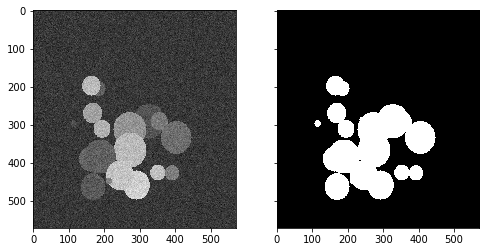

2018-09-30 14:42:29,908 Layers 5, features 32, filter size 3x3, pool size: 2x2
2018-09-30 14:42:31,764 Removing 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\prediction_unet_trained_toy_problem'
2018-09-30 14:42:31,778 Removing 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\unet_trained_toy_problem'
2018-09-30 14:42:31,792 Allocating 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\prediction_unet_trained_toy_problem'
2018-09-30 14:42:33,954 Verification error= 46.6%, loss= 0.6939
2018-09-30 14:42:34,564 Start optimization
2018-09-30 14:42:36,695 Iter 0, Minibatch Loss= 0.6368, Training Accuracy= 0.7563, Minibatch error= 24.4%
2018-09-30 14:42:38,073 Iter 2, Minibatch Loss= 0.6638, Training Accuracy= 0.6214, Minibatch error= 37.9%
2018-09-30 14:42:39,396 Iter 4, Minibatch Loss= 0.5807, Training Accuracy= 0.7234, Minibatch error= 27.7%
2018-09-30 14:42:40,762 Iter 6, Minibatch Loss= 0.6052, Training Accuracy= 0.6867, Minibatch error= 31.

2018-09-30 14:44:10,684 Iter 132, Minibatch Loss= 0.7010, Training Accuracy= 0.2215, Minibatch error= 77.8%
2018-09-30 14:44:12,209 Iter 134, Minibatch Loss= 0.6931, Training Accuracy= 0.6236, Minibatch error= 37.6%
2018-09-30 14:44:13,476 Iter 136, Minibatch Loss= 0.6931, Training Accuracy= 0.7223, Minibatch error= 27.8%
2018-09-30 14:44:14,749 Iter 138, Minibatch Loss= 0.6931, Training Accuracy= 0.6883, Minibatch error= 31.2%
2018-09-30 14:44:16,002 Iter 140, Minibatch Loss= 0.6931, Training Accuracy= 0.7107, Minibatch error= 28.9%
2018-09-30 14:44:17,355 Iter 142, Minibatch Loss= 0.6854, Training Accuracy= 0.8995, Minibatch error= 10.1%
2018-09-30 14:44:18,707 Iter 144, Minibatch Loss= 0.2485, Training Accuracy= 0.9147, Minibatch error= 8.5%
2018-09-30 14:44:20,057 Iter 146, Minibatch Loss= 0.2615, Training Accuracy= 0.9531, Minibatch error= 4.7%
2018-09-30 14:44:21,378 Iter 148, Minibatch Loss= 0.1362, Training Accuracy= 0.9504, Minibatch error= 5.0%
2018-09-30 14:44:22,659 Iter 15

2018-09-30 14:45:53,673 Iter 276, Minibatch Loss= 0.0514, Training Accuracy= 0.9866, Minibatch error= 1.3%
2018-09-30 14:45:55,137 Iter 278, Minibatch Loss= 0.2003, Training Accuracy= 0.9218, Minibatch error= 7.8%
2018-09-30 14:45:56,582 Iter 280, Minibatch Loss= 0.1040, Training Accuracy= 0.9638, Minibatch error= 3.6%
2018-09-30 14:45:57,895 Iter 282, Minibatch Loss= 0.2735, Training Accuracy= 0.9143, Minibatch error= 8.6%
2018-09-30 14:45:59,281 Iter 284, Minibatch Loss= 0.1775, Training Accuracy= 0.9395, Minibatch error= 6.1%
2018-09-30 14:46:00,614 Iter 286, Minibatch Loss= 0.1543, Training Accuracy= 0.9532, Minibatch error= 4.7%
2018-09-30 14:46:01,079 Epoch 8, Average loss: 0.1622, learning rate: 0.1327
2018-09-30 14:46:01,870 Verification error= 5.0%, loss= 0.1692
2018-09-30 14:46:03,926 Iter 288, Minibatch Loss= 0.0808, Training Accuracy= 0.9840, Minibatch error= 1.6%
2018-09-30 14:46:05,276 Iter 290, Minibatch Loss= 0.1757, Training Accuracy= 0.9525, Minibatch error= 4.7%
2018

2018-09-30 14:47:37,762 Iter 416, Minibatch Loss= 0.1418, Training Accuracy= 0.9485, Minibatch error= 5.2%
2018-09-30 14:47:39,102 Iter 418, Minibatch Loss= 0.1057, Training Accuracy= 0.9765, Minibatch error= 2.3%
2018-09-30 14:47:40,448 Iter 420, Minibatch Loss= 0.0383, Training Accuracy= 0.9882, Minibatch error= 1.2%
2018-09-30 14:47:41,770 Iter 422, Minibatch Loss= 0.0663, Training Accuracy= 0.9807, Minibatch error= 1.9%
2018-09-30 14:47:43,133 Iter 424, Minibatch Loss= 0.1186, Training Accuracy= 0.9626, Minibatch error= 3.7%
2018-09-30 14:47:44,447 Iter 426, Minibatch Loss= 0.0780, Training Accuracy= 0.9838, Minibatch error= 1.6%
2018-09-30 14:47:45,762 Iter 428, Minibatch Loss= 0.0859, Training Accuracy= 0.9697, Minibatch error= 3.0%
2018-09-30 14:47:47,103 Iter 430, Minibatch Loss= 0.1370, Training Accuracy= 0.9648, Minibatch error= 3.5%
2018-09-30 14:47:48,423 Iter 432, Minibatch Loss= 0.0845, Training Accuracy= 0.9782, Minibatch error= 2.2%
2018-09-30 14:47:49,998 Iter 434, Min

2018-09-30 14:49:23,152 Iter 560, Minibatch Loss= 0.1854, Training Accuracy= 0.9476, Minibatch error= 5.2%
2018-09-30 14:49:24,498 Iter 562, Minibatch Loss= 0.1415, Training Accuracy= 0.9589, Minibatch error= 4.1%
2018-09-30 14:49:25,852 Iter 564, Minibatch Loss= 0.0372, Training Accuracy= 0.9898, Minibatch error= 1.0%
2018-09-30 14:49:27,181 Iter 566, Minibatch Loss= 0.1315, Training Accuracy= 0.9517, Minibatch error= 4.8%
2018-09-30 14:49:28,587 Iter 568, Minibatch Loss= 0.2168, Training Accuracy= 0.9296, Minibatch error= 7.0%
2018-09-30 14:49:29,852 Iter 570, Minibatch Loss= 0.2602, Training Accuracy= 0.9346, Minibatch error= 6.5%
2018-09-30 14:49:31,170 Iter 572, Minibatch Loss= 0.2803, Training Accuracy= 0.9356, Minibatch error= 6.4%
2018-09-30 14:49:32,493 Iter 574, Minibatch Loss= 0.1425, Training Accuracy= 0.9434, Minibatch error= 5.7%
2018-09-30 14:49:32,968 Epoch 17, Average loss: 0.1471, learning rate: 0.0836
2018-09-30 14:49:33,755 Verification error= 6.3%, loss= 0.1819
201

In [38]:
#########################
#train(data_provider, folder, train_iter, epoch, train)
#Al terminar el entrenamiento se recomienda guardar el contenido de la carpeta unet_trained_*
#########################
model_toy_problem = pruebas_toy_problem.train(data_provider_toy_problem_train, 
                                              TRAINED_FOLDER_TOY_PROBLEM, 
                                              32, #iterations
                                              20, #epoch
                                              1, #batch size
                                              5, #layers
                                              32, #features
                                              0.5, #momentum
                                              ENTRENAR_BROAD_TOY_PROBLEM_MODEL)

Test

In [39]:
data_provider_toy_problem_test = data_provider_toy_problem_train

INFO:tensorflow:Restoring parameters from ./unet_trained_toy_problem/model.ckpt


2018-09-30 14:50:29,872 Restoring parameters from ./unet_trained_toy_problem/model.ckpt
2018-09-30 14:50:30,107 Model restored from file: ./unet_trained_toy_problem/model.ckpt


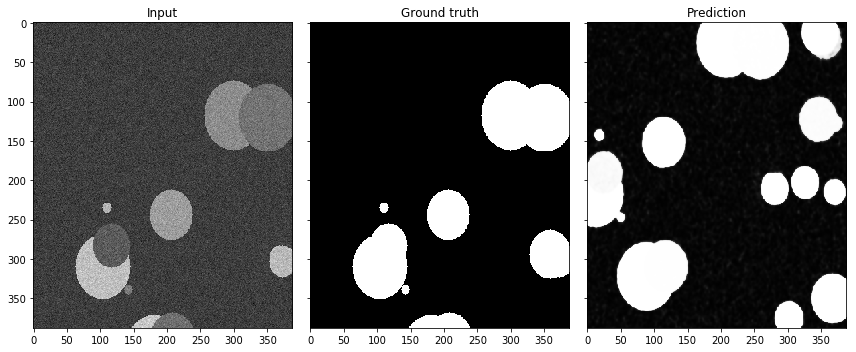

In [40]:
pruebas_toy_problem.test(model_toy_problem, data_provider_toy_problem_test, TRAINED_FOLDER_TOY_PROBLEM)

### EM segmentation challenge - ISBI 2012 (línea base)
- http://brainiac2.mit.edu/isbi_challenge/
- Es la que usan en el paper base (Ronneberger et al., 2015)
- Resolución: 512 x 512 x 30
- No existen imágenes de máscaras para conjunto de pruebas

In [61]:
PATH_ISBI_2012_TRAIN = "dataset/isbi-challenge/train/"
PATH_ISBI_2012_TEST_ORIGINAL = "dataset/isbi-challenge/test-original/"
PATH_ISBI_2012_TEST_MASK = "dataset/isbi-challenge/test-mask/"
TRAINED_FOLDER_ISBI_2012 = "unet_trained_isbi_2012"
#########################
#True: Volver a entrenar el modelo
#False: Reutiliza los modelos ya entrenados con formado ckpt
#########################
ENTRENAR_BROAD_ISBI_2012_MODEL = False

Train

In [43]:
#######################################
#Fuente: elaboración propia
#Clase para separar los frames que una imagen TIF
#Util cuando no se tiene imágenes de test
#######################################
class ImageSeparator:
    
    def borrar_archivos(self, path):
        for root, dirs, files in os.walk(path):
            for file in files:
                os.remove(os.path.join(root, file))   
    
    def separar_tif(self, image_path_train, image_path_label, path_copy):
        
        path_train = path_copy + "train"
        path_test = path_copy + "test-mask"
        
        #obtenemos las imágenes y las guardamos en un arreglo
        ids = []
        images_train = []
        tif_image = Image.open(image_path_train)
        n_frames = tif_image.n_frames
        print("La imagenes tiene: " + str(n_frames) + " frames/capas")
        for i in range(0, n_frames):
            tif_image.seek(i)
            ids.append(i)
            images_train.append(tif_image.copy())
            
        #obtenemos las imágenes de los label y las guardamos en un arreglo
        images_label = []
        tif_label = Image.open(image_path_label)
        for i in range(0, n_frames):
            tif_label.seek(i)
            images_label.append(tif_label.copy())            

        #mezclamos aleatoreamente el arreglo de imágenes
        np.random.seed(0) #cambiar la semilla si quieren generar de nuevo
        np.random.shuffle(ids)

        #separamos conjunto de entrenamiento (70%) y pruebas (30%)
        n_frames_train = int(n_frames * 0.7)
        print("Total de imágenes de entrenamiento (70%): " + str(n_frames_train))
        print("Total de imágenes de prueba (30%): " + str(n_frames - n_frames_train))

        #borramos los archivos actuales
        self.borrar_archivos(path_train)
        self.borrar_archivos(path_test)

        #guardamos las imágenes de entrenamiento
        for i in range(0, n_frames_train):
            new_name_file = path_copy + "train/train" + "-" + str(i)
            images_train[ids[i]].save(new_name_file + ".tif")
            images_label[ids[i]].save(new_name_file + "_mask.tif")

        #guardamos las imágenes de prueba    
        for i in range(n_frames_train, n_frames):
            new_name_file = path_copy + "test-mask/test" + "-" + str(i)
            images_train[ids[i]].save(new_name_file + ".tif")
            images_label[ids[i]].save(new_name_file + "_mask.tif")
            
        print("Fin de proceso")

    def separarImagenesIsbiChallenge(self, generar):
        if generar:
            #Las imágenes de entrenamiento tienen que tener la misma cantidad de capas que los labels
            IMAGE_PATH_TRAIN = "dataset/isbi-challenge/original/train-volume.tif"
            IMAGE_PATH_LABEL = "dataset/isbi-challenge/original/train-labels.tif"
            self.separar_tif(IMAGE_PATH_TRAIN, IMAGE_PATH_LABEL, "dataset/isbi-challenge/")            

In [44]:
imageSeparator = ImageSeparator()
#Pasar a false si ya tienen generadas las imágenes
imageSeparator.separarImagenesIsbiChallenge(True)

La imagenes tiene: 30 frames/capas
Total de imágenes de entrenamiento (70%): 21
Total de imágenes de prueba (30%): 9
Fin de proceso


In [45]:
data_provider_isbi_2012_train = ImageDataProvider(PATH_ISBI_2012_TRAIN + "*.tif")

Number of files used: 21


In [46]:
#Ejecuta esta línea para reflejar los cambios en la clase Pruebas
pruebas_isbi_2012 = Pruebas();

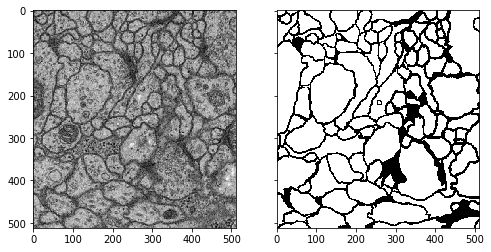

2018-09-30 14:58:04,252 Layers 5, features 32, filter size 3x3, pool size: 2x2
2018-09-30 14:58:06,168 Removing 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\prediction_unet_trained_isbi_2012'
2018-09-30 14:58:06,186 Removing 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\unet_trained_isbi_2012'
2018-09-30 14:58:06,203 Allocating 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\prediction_unet_trained_isbi_2012'
2018-09-30 14:58:07,886 Verification error= 77.2%, loss= 0.7285
2018-09-30 14:58:08,473 Start optimization
2018-09-30 14:58:10,440 Iter 0, Minibatch Loss= 0.6765, Training Accuracy= 0.7204, Minibatch error= 28.0%
2018-09-30 14:58:11,411 Iter 2, Minibatch Loss= 0.6025, Training Accuracy= 0.7696, Minibatch error= 23.0%
2018-09-30 14:58:12,413 Iter 4, Minibatch Loss= 0.5563, Training Accuracy= 0.7629, Minibatch error= 23.7%
2018-09-30 14:58:13,430 Iter 6, Minibatch Loss= 0.4734, Training Accuracy= 0.8130, Minibatch error= 18.7%
201

2018-09-30 14:59:22,647 Iter 132, Minibatch Loss= 0.3857, Training Accuracy= 0.7860, Minibatch error= 21.4%
2018-09-30 14:59:23,627 Iter 134, Minibatch Loss= 0.3355, Training Accuracy= 0.8083, Minibatch error= 19.2%
2018-09-30 14:59:24,638 Iter 136, Minibatch Loss= 0.4081, Training Accuracy= 0.8267, Minibatch error= 17.3%
2018-09-30 14:59:25,613 Iter 138, Minibatch Loss= 0.3484, Training Accuracy= 0.8288, Minibatch error= 17.1%
2018-09-30 14:59:26,600 Iter 140, Minibatch Loss= 0.3444, Training Accuracy= 0.8429, Minibatch error= 15.7%
2018-09-30 14:59:27,579 Iter 142, Minibatch Loss= 0.3645, Training Accuracy= 0.7803, Minibatch error= 22.0%
2018-09-30 14:59:28,550 Iter 144, Minibatch Loss= 0.4181, Training Accuracy= 0.8177, Minibatch error= 18.2%
2018-09-30 14:59:29,552 Iter 146, Minibatch Loss= 0.3453, Training Accuracy= 0.8084, Minibatch error= 19.2%
2018-09-30 14:59:30,512 Iter 148, Minibatch Loss= 0.3656, Training Accuracy= 0.8184, Minibatch error= 18.2%
2018-09-30 14:59:31,517 Iter

2018-09-30 15:00:37,966 Iter 274, Minibatch Loss= 0.3480, Training Accuracy= 0.8156, Minibatch error= 18.4%
2018-09-30 15:00:39,229 Iter 276, Minibatch Loss= 0.3380, Training Accuracy= 0.8273, Minibatch error= 17.3%
2018-09-30 15:00:40,266 Iter 278, Minibatch Loss= 0.3816, Training Accuracy= 0.7787, Minibatch error= 22.1%
2018-09-30 15:00:41,300 Iter 280, Minibatch Loss= 0.3112, Training Accuracy= 0.8688, Minibatch error= 13.1%
2018-09-30 15:00:42,271 Iter 282, Minibatch Loss= 0.3143, Training Accuracy= 0.8620, Minibatch error= 13.8%
2018-09-30 15:00:43,237 Iter 284, Minibatch Loss= 0.3422, Training Accuracy= 0.8363, Minibatch error= 16.4%
2018-09-30 15:00:44,241 Iter 286, Minibatch Loss= 0.3764, Training Accuracy= 0.8272, Minibatch error= 17.3%
2018-09-30 15:00:44,564 Epoch 8, Average loss: 0.3702, learning rate: 0.1327
2018-09-30 15:00:45,163 Verification error= 20.6%, loss= 0.3823
2018-09-30 15:00:46,745 Iter 288, Minibatch Loss= 0.3817, Training Accuracy= 0.7940, Minibatch error= 2

2018-09-30 15:01:53,246 Epoch 12, Average loss: 0.3690, learning rate: 0.1081
2018-09-30 15:01:53,847 Verification error= 17.9%, loss= 0.3398
2018-09-30 15:01:55,419 Iter 416, Minibatch Loss= 0.3434, Training Accuracy= 0.8111, Minibatch error= 18.9%
2018-09-30 15:01:56,380 Iter 418, Minibatch Loss= 0.3638, Training Accuracy= 0.8351, Minibatch error= 16.5%
2018-09-30 15:01:57,333 Iter 420, Minibatch Loss= 0.2852, Training Accuracy= 0.8574, Minibatch error= 14.3%
2018-09-30 15:01:58,306 Iter 422, Minibatch Loss= 0.3681, Training Accuracy= 0.7942, Minibatch error= 20.6%
2018-09-30 15:01:59,277 Iter 424, Minibatch Loss= 0.3317, Training Accuracy= 0.8416, Minibatch error= 15.8%
2018-09-30 15:02:00,230 Iter 426, Minibatch Loss= 0.3466, Training Accuracy= 0.8419, Minibatch error= 15.8%
2018-09-30 15:02:01,242 Iter 428, Minibatch Loss= 0.3496, Training Accuracy= 0.8293, Minibatch error= 17.1%
2018-09-30 15:02:02,211 Iter 430, Minibatch Loss= 0.3123, Training Accuracy= 0.8694, Minibatch error= 

2018-09-30 15:03:10,641 Iter 556, Minibatch Loss= 0.3516, Training Accuracy= 0.8106, Minibatch error= 18.9%
2018-09-30 15:03:11,636 Iter 558, Minibatch Loss= 0.3260, Training Accuracy= 0.8485, Minibatch error= 15.1%
2018-09-30 15:03:12,592 Iter 560, Minibatch Loss= 0.3703, Training Accuracy= 0.8287, Minibatch error= 17.1%
2018-09-30 15:03:13,548 Iter 562, Minibatch Loss= 0.3581, Training Accuracy= 0.8072, Minibatch error= 19.3%
2018-09-30 15:03:14,533 Iter 564, Minibatch Loss= 0.2989, Training Accuracy= 0.8594, Minibatch error= 14.1%
2018-09-30 15:03:15,507 Iter 566, Minibatch Loss= 0.3229, Training Accuracy= 0.8493, Minibatch error= 15.1%
2018-09-30 15:03:16,539 Iter 568, Minibatch Loss= 0.4116, Training Accuracy= 0.7691, Minibatch error= 23.1%
2018-09-30 15:03:17,525 Iter 570, Minibatch Loss= 0.3092, Training Accuracy= 0.8537, Minibatch error= 14.6%
2018-09-30 15:03:18,773 Iter 572, Minibatch Loss= 0.3804, Training Accuracy= 0.7846, Minibatch error= 21.5%
2018-09-30 15:03:19,848 Iter

2018-09-30 15:04:27,638 Iter 698, Minibatch Loss= 0.3554, Training Accuracy= 0.8290, Minibatch error= 17.1%
2018-09-30 15:04:28,663 Iter 700, Minibatch Loss= 0.3362, Training Accuracy= 0.8415, Minibatch error= 15.9%
2018-09-30 15:04:29,644 Iter 702, Minibatch Loss= 0.3061, Training Accuracy= 0.8491, Minibatch error= 15.1%
2018-09-30 15:04:29,960 Epoch 21, Average loss: 0.3448, learning rate: 0.0681
2018-09-30 15:04:30,587 Verification error= 15.5%, loss= 0.3209
2018-09-30 15:04:32,644 Iter 704, Minibatch Loss= 0.2654, Training Accuracy= 0.8765, Minibatch error= 12.3%
2018-09-30 15:04:33,684 Iter 706, Minibatch Loss= 0.3371, Training Accuracy= 0.8414, Minibatch error= 15.9%
2018-09-30 15:04:34,695 Iter 708, Minibatch Loss= 0.3102, Training Accuracy= 0.8567, Minibatch error= 14.3%
2018-09-30 15:04:35,889 Iter 710, Minibatch Loss= 0.3101, Training Accuracy= 0.8550, Minibatch error= 14.5%
2018-09-30 15:04:36,889 Iter 712, Minibatch Loss= 0.3261, Training Accuracy= 0.8526, Minibatch error= 

2018-09-30 15:05:45,060 Iter 838, Minibatch Loss= 0.3864, Training Accuracy= 0.8300, Minibatch error= 17.0%
2018-09-30 15:05:46,045 Iter 840, Minibatch Loss= 0.4166, Training Accuracy= 0.7798, Minibatch error= 22.0%
2018-09-30 15:05:47,016 Iter 842, Minibatch Loss= 0.2666, Training Accuracy= 0.8843, Minibatch error= 11.6%
2018-09-30 15:05:47,967 Iter 844, Minibatch Loss= 0.2732, Training Accuracy= 0.8751, Minibatch error= 12.5%
2018-09-30 15:05:48,900 Iter 846, Minibatch Loss= 0.3043, Training Accuracy= 0.8676, Minibatch error= 13.2%
2018-09-30 15:05:49,878 Iter 848, Minibatch Loss= 0.3033, Training Accuracy= 0.8685, Minibatch error= 13.2%
2018-09-30 15:05:50,834 Iter 850, Minibatch Loss= 0.2866, Training Accuracy= 0.8721, Minibatch error= 12.8%
2018-09-30 15:05:51,852 Iter 852, Minibatch Loss= 0.3177, Training Accuracy= 0.8666, Minibatch error= 13.3%
2018-09-30 15:05:52,847 Iter 854, Minibatch Loss= 0.2999, Training Accuracy= 0.8666, Minibatch error= 13.3%
2018-09-30 15:05:53,885 Iter

2018-09-30 15:07:01,259 Iter 980, Minibatch Loss= 0.3292, Training Accuracy= 0.8580, Minibatch error= 14.2%
2018-09-30 15:07:02,271 Iter 982, Minibatch Loss= 0.2704, Training Accuracy= 0.8774, Minibatch error= 12.3%
2018-09-30 15:07:03,227 Iter 984, Minibatch Loss= 0.2917, Training Accuracy= 0.8777, Minibatch error= 12.2%
2018-09-30 15:07:04,166 Iter 986, Minibatch Loss= 0.2309, Training Accuracy= 0.8966, Minibatch error= 10.3%
2018-09-30 15:07:05,164 Iter 988, Minibatch Loss= 0.3621, Training Accuracy= 0.8431, Minibatch error= 15.7%
2018-09-30 15:07:06,146 Iter 990, Minibatch Loss= 0.2662, Training Accuracy= 0.8776, Minibatch error= 12.2%
2018-09-30 15:07:06,452 Epoch 30, Average loss: 0.3106, learning rate: 0.0429
2018-09-30 15:07:07,068 Verification error= 15.0%, loss= 0.3190
2018-09-30 15:07:08,952 Iter 992, Minibatch Loss= 0.2869, Training Accuracy= 0.8765, Minibatch error= 12.4%
2018-09-30 15:07:09,941 Iter 994, Minibatch Loss= 0.2992, Training Accuracy= 0.8655, Minibatch error= 

2018-09-30 15:08:16,330 Verification error= 11.8%, loss= 0.2732
2018-09-30 15:08:18,149 Iter 1120, Minibatch Loss= 0.3518, Training Accuracy= 0.8196, Minibatch error= 18.0%
2018-09-30 15:08:19,096 Iter 1122, Minibatch Loss= 0.2866, Training Accuracy= 0.8752, Minibatch error= 12.5%
2018-09-30 15:08:20,047 Iter 1124, Minibatch Loss= 0.2965, Training Accuracy= 0.8674, Minibatch error= 13.3%
2018-09-30 15:08:21,002 Iter 1126, Minibatch Loss= 0.2547, Training Accuracy= 0.8893, Minibatch error= 11.1%
2018-09-30 15:08:21,965 Iter 1128, Minibatch Loss= 0.2977, Training Accuracy= 0.8728, Minibatch error= 12.7%
2018-09-30 15:08:22,916 Iter 1130, Minibatch Loss= 0.2955, Training Accuracy= 0.8796, Minibatch error= 12.0%
2018-09-30 15:08:23,888 Iter 1132, Minibatch Loss= 0.2758, Training Accuracy= 0.8760, Minibatch error= 12.4%
2018-09-30 15:08:24,862 Iter 1134, Minibatch Loss= 0.2795, Training Accuracy= 0.8736, Minibatch error= 12.6%
2018-09-30 15:08:25,803 Iter 1136, Minibatch Loss= 0.2980, Train

2018-09-30 15:09:34,153 Iter 1260, Minibatch Loss= 0.2876, Training Accuracy= 0.8799, Minibatch error= 12.0%
2018-09-30 15:09:35,125 Iter 1262, Minibatch Loss= 0.2908, Training Accuracy= 0.8813, Minibatch error= 11.9%
2018-09-30 15:09:36,097 Iter 1264, Minibatch Loss= 0.3102, Training Accuracy= 0.8616, Minibatch error= 13.8%
2018-09-30 15:09:37,051 Iter 1266, Minibatch Loss= 0.2770, Training Accuracy= 0.8791, Minibatch error= 12.1%
2018-09-30 15:09:38,013 Iter 1268, Minibatch Loss= 0.3670, Training Accuracy= 0.8169, Minibatch error= 18.3%
2018-09-30 15:09:38,986 Iter 1270, Minibatch Loss= 0.2649, Training Accuracy= 0.8853, Minibatch error= 11.5%
2018-09-30 15:09:39,935 Iter 1272, Minibatch Loss= 0.2876, Training Accuracy= 0.8690, Minibatch error= 13.1%
2018-09-30 15:09:40,903 Iter 1274, Minibatch Loss= 0.2841, Training Accuracy= 0.8819, Minibatch error= 11.8%
2018-09-30 15:09:41,876 Iter 1276, Minibatch Loss= 0.2742, Training Accuracy= 0.8773, Minibatch error= 12.3%
2018-09-30 15:09:42

2018-09-30 15:10:50,991 Iter 1400, Minibatch Loss= 0.2315, Training Accuracy= 0.8920, Minibatch error= 10.8%
2018-09-30 15:10:51,957 Iter 1402, Minibatch Loss= 0.3364, Training Accuracy= 0.8516, Minibatch error= 14.8%
2018-09-30 15:10:52,978 Iter 1404, Minibatch Loss= 0.2875, Training Accuracy= 0.8833, Minibatch error= 11.7%
2018-09-30 15:10:53,964 Iter 1406, Minibatch Loss= 0.2795, Training Accuracy= 0.8772, Minibatch error= 12.3%
2018-09-30 15:10:54,274 Epoch 43, Average loss: 0.3028, learning rate: 0.0220
2018-09-30 15:10:54,889 Verification error= 11.9%, loss= 0.2715
2018-09-30 15:10:56,969 Iter 1408, Minibatch Loss= 0.2949, Training Accuracy= 0.8705, Minibatch error= 13.0%
2018-09-30 15:10:57,942 Iter 1410, Minibatch Loss= 0.2865, Training Accuracy= 0.8627, Minibatch error= 13.7%
2018-09-30 15:10:58,917 Iter 1412, Minibatch Loss= 0.3008, Training Accuracy= 0.8718, Minibatch error= 12.8%
2018-09-30 15:10:59,845 Iter 1414, Minibatch Loss= 0.2864, Training Accuracy= 0.8733, Minibatch

2018-09-30 15:12:08,297 Iter 1538, Minibatch Loss= 0.2733, Training Accuracy= 0.8853, Minibatch error= 11.5%
2018-09-30 15:12:09,498 Iter 1540, Minibatch Loss= 0.2841, Training Accuracy= 0.8710, Minibatch error= 12.9%
2018-09-30 15:12:10,461 Iter 1542, Minibatch Loss= 0.2653, Training Accuracy= 0.8874, Minibatch error= 11.3%
2018-09-30 15:12:11,445 Iter 1544, Minibatch Loss= 0.2588, Training Accuracy= 0.8951, Minibatch error= 10.5%
2018-09-30 15:12:12,392 Iter 1546, Minibatch Loss= 0.2839, Training Accuracy= 0.8650, Minibatch error= 13.5%
2018-09-30 15:12:13,358 Iter 1548, Minibatch Loss= 0.2905, Training Accuracy= 0.8733, Minibatch error= 12.7%
2018-09-30 15:12:14,357 Iter 1550, Minibatch Loss= 0.2738, Training Accuracy= 0.8845, Minibatch error= 11.6%
2018-09-30 15:12:15,325 Iter 1552, Minibatch Loss= 0.2617, Training Accuracy= 0.8847, Minibatch error= 11.5%
2018-09-30 15:12:16,361 Iter 1554, Minibatch Loss= 0.2597, Training Accuracy= 0.8933, Minibatch error= 10.7%
2018-09-30 15:12:17

In [52]:
#########################
#train(data_provider, folder, train_iter, epoch, train)
#Al terminar el entrenamiento se recomienda guardar el contenido de la carpeta unet_trained_*
#########################
model_isbi_2012 = pruebas_isbi_2012.train(data_provider_isbi_2012_train, 
                                          TRAINED_FOLDER_ISBI_2012, 
                                          32, #iterations
                                          50, #epoch
                                          1, #batch size
                                          5, #layers
                                          32, #features
                                          0.5, #momentum
                                          ENTRENAR_BROAD_ISBI_2012_MODEL)

Test
- Este conjunto de prueba no tiene labels con cual comparar

In [53]:
data_provider_isbi_2012_test = ImageDataProvider(PATH_ISBI_2012_TEST_ORIGINAL + "*.tif")

Number of files used: 1


INFO:tensorflow:Restoring parameters from ./unet_trained_isbi_2012/model.ckpt


2018-09-30 15:12:50,134 Restoring parameters from ./unet_trained_isbi_2012/model.ckpt
2018-09-30 15:12:50,443 Model restored from file: ./unet_trained_isbi_2012/model.ckpt


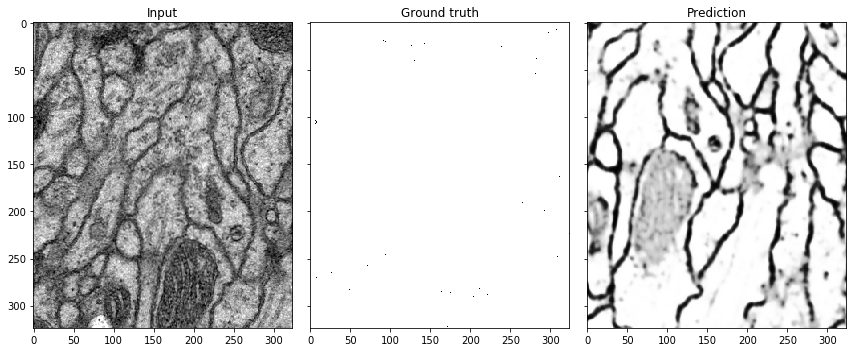

In [54]:
pruebas_isbi_2012.test(model_isbi_2012, data_provider_isbi_2012_test, TRAINED_FOLDER_ISBI_2012)

Test
- Utilizamos los labels reservados de la imagen original para poder hacer las comparaciones

In [55]:
data_provider_isbi_2012_test_mask = ImageDataProvider(PATH_ISBI_2012_TEST_MASK + "*.tif")

Number of files used: 9


INFO:tensorflow:Restoring parameters from ./unet_trained_isbi_2012/model.ckpt


2018-09-30 15:12:56,435 Restoring parameters from ./unet_trained_isbi_2012/model.ckpt
2018-09-30 15:12:56,731 Model restored from file: ./unet_trained_isbi_2012/model.ckpt


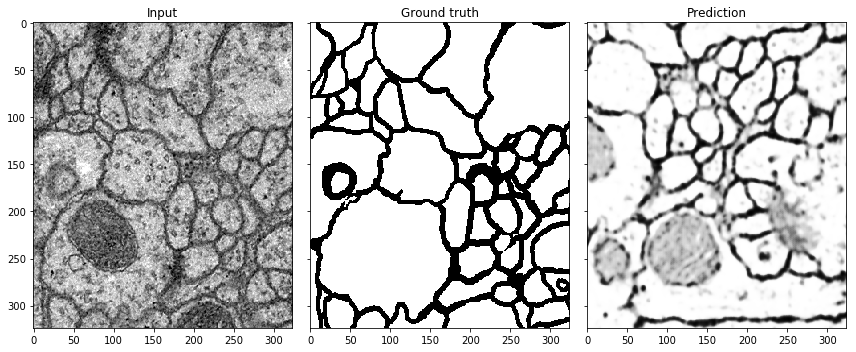

In [56]:
pruebas_isbi_2012.test(model_isbi_2012, data_provider_isbi_2012_test_mask, TRAINED_FOLDER_ISBI_2012)

### Cell Tracking Challenge (línea base)
- http://www.celltrackingchallenge.net/datasets.html
- Solo existe una imagen sin máscara
- Se necesitan buscar reemplazos de ambos conjuntos

PhC-U373 - PhC-C2DH-U373
- Glioblastoma-astrocytoma U373 cells on a polyacrylimide substrate  (2D)
- Dr. Sanjay Kumar. Department of Bioengineering
- University of California at Berkeley. Berkeley CA (USA)
- Microscope: Nikon
- Objective lens: Plan Fluor DLL 20X/0.5
- Pixel size (microns): 0.65 x 0.65
- Time step (min): 15

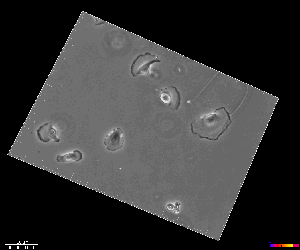

In [58]:
img = Image.open("img/PhC-C2DH-U373.gif")
img = img.resize((300, 250), Image.ANTIALIAS)
img

DIC-HeLA - Fluo-N2DL-HeLa
- HeLa cells stably expressing H2b-GFP (2D)
- Mitocheck Consortium
- Microscope: Olympus IX81
- Objective lens: Plan 10x/0.4
- Pixel size (microns): 0.645 x 0.645
- Time step (min): 30

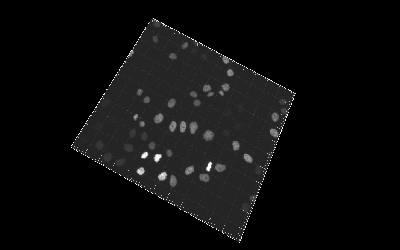

In [59]:
img = Image.open("img/N2DL-HeLa.gif")
img = img.resize((400, 250), Image.ANTIALIAS)
img

### Broad Bioimage Benchmark Collection (BBBC003)
- Embriones de ratones.
- Modo de toma: Fluor
- https://data.broadinstitute.org/bbbc/BBBC003/
- Todas las imágenes deben tener la misma orientación (horizontal o vertical). Se modificaron manualmente.

In [69]:
PATH_BROAD_003_TRAIN = "dataset/broad-bioimage/BBBC003/train/"
PATH_BROAD_003_TEST = "dataset/broad-bioimage/BBBC003/test/"
TRAINED_FOLDER_BROAD_003 = "unet_trained_broad_003"
#########################
#True: Volver a entrenar el modelo
#False: Reutiliza los modelos ya entrenados con formado ckpt
#########################
ENTRENAR_BROAD_003_MODEL = False 

Train

In [63]:
data_provider_broad_003_train = ImageDataProvider(PATH_BROAD_003_TRAIN + "*.tif")

Number of files used: 11


In [64]:
#Ejecuta esta línea para reflejar los cambios en la clase Pruebas
pruebas_broad_003 = Pruebas();

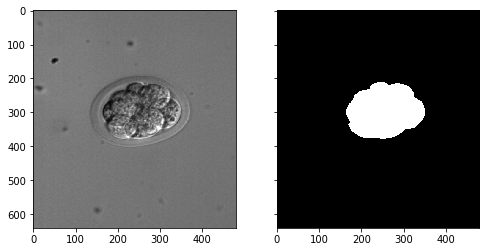

2018-09-30 15:14:29,199 Layers 5, features 32, filter size 3x3, pool size: 2x2
2018-09-30 15:14:31,388 Removing 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\prediction_unet_trained_broad_003'
2018-09-30 15:14:31,388 Removing 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\unet_trained_broad_003'
2018-09-30 15:14:31,402 Allocating 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\prediction_unet_trained_broad_003'
2018-09-30 15:14:33,252 Verification error= 19.5%, loss= 0.6842
2018-09-30 15:14:33,857 Start optimization
2018-09-30 15:14:35,953 Iter 0, Minibatch Loss= 0.6070, Training Accuracy= 0.8259, Minibatch error= 17.4%
2018-09-30 15:14:37,037 Iter 2, Minibatch Loss= 0.5065, Training Accuracy= 0.8239, Minibatch error= 17.6%
2018-09-30 15:14:38,118 Iter 4, Minibatch Loss= 0.5071, Training Accuracy= 0.7950, Minibatch error= 20.5%
2018-09-30 15:14:39,190 Iter 6, Minibatch Loss= 0.5030, Training Accuracy= 0.7972, Minibatch error= 20.3%
201

2018-09-30 15:15:55,681 Iter 132, Minibatch Loss= 0.4210, Training Accuracy= 0.8223, Minibatch error= 17.8%
2018-09-30 15:15:56,750 Iter 134, Minibatch Loss= 0.4545, Training Accuracy= 0.8019, Minibatch error= 19.8%
2018-09-30 15:15:57,834 Iter 136, Minibatch Loss= 0.4331, Training Accuracy= 0.7849, Minibatch error= 21.5%
2018-09-30 15:15:58,938 Iter 138, Minibatch Loss= 0.4011, Training Accuracy= 0.8086, Minibatch error= 19.1%
2018-09-30 15:16:00,109 Iter 140, Minibatch Loss= 0.4277, Training Accuracy= 0.8019, Minibatch error= 19.8%
2018-09-30 15:16:01,275 Iter 142, Minibatch Loss= 0.4070, Training Accuracy= 0.7973, Minibatch error= 20.3%
2018-09-30 15:16:02,383 Iter 144, Minibatch Loss= 0.6007, Training Accuracy= 0.7842, Minibatch error= 21.6%
2018-09-30 15:16:03,484 Iter 146, Minibatch Loss= 0.4627, Training Accuracy= 0.8087, Minibatch error= 19.1%
2018-09-30 15:16:04,574 Iter 148, Minibatch Loss= 0.4367, Training Accuracy= 0.8240, Minibatch error= 17.6%
2018-09-30 15:16:05,679 Iter

2018-09-30 15:17:20,474 Iter 274, Minibatch Loss= 0.5050, Training Accuracy= 0.7950, Minibatch error= 20.5%
2018-09-30 15:17:21,561 Iter 276, Minibatch Loss= 0.4979, Training Accuracy= 0.7972, Minibatch error= 20.3%
2018-09-30 15:17:22,628 Iter 278, Minibatch Loss= 0.5087, Training Accuracy= 0.7841, Minibatch error= 21.6%
2018-09-30 15:17:23,689 Iter 280, Minibatch Loss= 0.4480, Training Accuracy= 0.8239, Minibatch error= 17.6%
2018-09-30 15:17:24,750 Iter 282, Minibatch Loss= 0.4940, Training Accuracy= 0.7849, Minibatch error= 21.5%
2018-09-30 15:17:25,832 Iter 284, Minibatch Loss= 0.4543, Training Accuracy= 0.8086, Minibatch error= 19.1%
2018-09-30 15:17:26,888 Iter 286, Minibatch Loss= 0.4236, Training Accuracy= 0.8223, Minibatch error= 17.8%
2018-09-30 15:17:27,254 Epoch 8, Average loss: 0.4829, learning rate: 0.1327
2018-09-30 15:17:27,989 Verification error= 19.6%, loss= 0.4560
2018-09-30 15:17:29,663 Iter 288, Minibatch Loss= 0.5475, Training Accuracy= 0.7428, Minibatch error= 2

2018-09-30 15:18:42,265 Epoch 12, Average loss: 0.4869, learning rate: 0.1081
2018-09-30 15:18:42,991 Verification error= 19.3%, loss= 0.4894
2018-09-30 15:18:44,794 Iter 416, Minibatch Loss= 0.5020, Training Accuracy= 0.7996, Minibatch error= 20.0%
2018-09-30 15:18:45,816 Iter 418, Minibatch Loss= 0.5121, Training Accuracy= 0.7858, Minibatch error= 21.4%
2018-09-30 15:18:46,854 Iter 420, Minibatch Loss= 0.4508, Training Accuracy= 0.8294, Minibatch error= 17.1%
2018-09-30 15:18:47,881 Iter 422, Minibatch Loss= 0.4575, Training Accuracy= 0.8249, Minibatch error= 17.5%
2018-09-30 15:18:48,943 Iter 424, Minibatch Loss= 0.5060, Training Accuracy= 0.7892, Minibatch error= 21.1%
2018-09-30 15:18:49,956 Iter 426, Minibatch Loss= 0.5103, Training Accuracy= 0.7863, Minibatch error= 21.4%
2018-09-30 15:18:51,009 Iter 428, Minibatch Loss= 0.4482, Training Accuracy= 0.8306, Minibatch error= 16.9%
2018-09-30 15:18:52,024 Iter 430, Minibatch Loss= 0.4463, Training Accuracy= 0.8298, Minibatch error= 

2018-09-30 15:20:06,984 Iter 556, Minibatch Loss= 0.3796, Training Accuracy= 0.8750, Minibatch error= 12.5%
2018-09-30 15:20:08,079 Iter 558, Minibatch Loss= 0.4579, Training Accuracy= 0.8526, Minibatch error= 14.7%
2018-09-30 15:20:09,148 Iter 560, Minibatch Loss= 0.3894, Training Accuracy= 0.8683, Minibatch error= 13.2%
2018-09-30 15:20:10,223 Iter 562, Minibatch Loss= 0.3041, Training Accuracy= 0.8954, Minibatch error= 10.5%
2018-09-30 15:20:11,326 Iter 564, Minibatch Loss= 0.3986, Training Accuracy= 0.8298, Minibatch error= 17.0%
2018-09-30 15:20:12,364 Iter 566, Minibatch Loss= 0.3104, Training Accuracy= 0.8813, Minibatch error= 11.9%
2018-09-30 15:20:13,435 Iter 568, Minibatch Loss= 0.2707, Training Accuracy= 0.8910, Minibatch error= 10.9%
2018-09-30 15:20:14,534 Iter 570, Minibatch Loss= 0.5100, Training Accuracy= 0.7912, Minibatch error= 20.9%
2018-09-30 15:20:15,586 Iter 572, Minibatch Loss= 0.3223, Training Accuracy= 0.8760, Minibatch error= 12.4%
2018-09-30 15:20:16,668 Iter

2018-09-30 15:21:29,487 Iter 698, Minibatch Loss= 0.3461, Training Accuracy= 0.8856, Minibatch error= 11.4%
2018-09-30 15:21:30,500 Iter 700, Minibatch Loss= 0.3877, Training Accuracy= 0.8593, Minibatch error= 14.1%
2018-09-30 15:21:31,501 Iter 702, Minibatch Loss= 0.3230, Training Accuracy= 0.8967, Minibatch error= 10.3%
2018-09-30 15:21:31,871 Epoch 21, Average loss: 0.4083, learning rate: 0.0681
2018-09-30 15:21:32,599 Verification error= 12.7%, loss= 0.3704
2018-09-30 15:21:34,313 Iter 704, Minibatch Loss= 0.3481, Training Accuracy= 0.8804, Minibatch error= 12.0%
2018-09-30 15:21:35,346 Iter 706, Minibatch Loss= 0.3047, Training Accuracy= 0.9047, Minibatch error= 9.5%
2018-09-30 15:21:36,388 Iter 708, Minibatch Loss= 0.4888, Training Accuracy= 0.8035, Minibatch error= 19.7%
2018-09-30 15:21:37,421 Iter 710, Minibatch Loss= 0.3477, Training Accuracy= 0.8797, Minibatch error= 12.0%
2018-09-30 15:21:38,473 Iter 712, Minibatch Loss= 0.3075, Training Accuracy= 0.9043, Minibatch error= 9

2018-09-30 15:22:53,143 Iter 838, Minibatch Loss= 0.4324, Training Accuracy= 0.8423, Minibatch error= 15.8%
2018-09-30 15:22:54,218 Iter 840, Minibatch Loss= 0.3625, Training Accuracy= 0.8785, Minibatch error= 12.2%
2018-09-30 15:22:55,245 Iter 842, Minibatch Loss= 0.5097, Training Accuracy= 0.7870, Minibatch error= 21.3%
2018-09-30 15:22:56,299 Iter 844, Minibatch Loss= 0.4139, Training Accuracy= 0.8498, Minibatch error= 15.0%
2018-09-30 15:22:57,338 Iter 846, Minibatch Loss= 0.4872, Training Accuracy= 0.7975, Minibatch error= 20.3%
2018-09-30 15:22:58,372 Iter 848, Minibatch Loss= 0.3446, Training Accuracy= 0.8892, Minibatch error= 11.1%
2018-09-30 15:22:59,397 Iter 850, Minibatch Loss= 0.3178, Training Accuracy= 0.9046, Minibatch error= 9.5%
2018-09-30 15:23:00,450 Iter 852, Minibatch Loss= 0.3408, Training Accuracy= 0.8872, Minibatch error= 11.3%
2018-09-30 15:23:01,513 Iter 854, Minibatch Loss= 0.3685, Training Accuracy= 0.8867, Minibatch error= 11.3%
2018-09-30 15:23:02,603 Iter 

2018-09-30 15:24:15,649 Iter 980, Minibatch Loss= 0.2133, Training Accuracy= 0.9349, Minibatch error= 6.5%
2018-09-30 15:24:16,694 Iter 982, Minibatch Loss= 0.1603, Training Accuracy= 0.9430, Minibatch error= 5.7%
2018-09-30 15:24:17,730 Iter 984, Minibatch Loss= 0.1549, Training Accuracy= 0.9485, Minibatch error= 5.1%
2018-09-30 15:24:18,763 Iter 986, Minibatch Loss= 0.1471, Training Accuracy= 0.9461, Minibatch error= 5.4%
2018-09-30 15:24:19,819 Iter 988, Minibatch Loss= 0.1186, Training Accuracy= 0.9505, Minibatch error= 4.9%
2018-09-30 15:24:20,859 Iter 990, Minibatch Loss= 0.1915, Training Accuracy= 0.9305, Minibatch error= 7.0%
2018-09-30 15:24:21,229 Epoch 30, Average loss: 0.2023, learning rate: 0.0429
2018-09-30 15:24:21,958 Verification error= 5.2%, loss= 0.1300
2018-09-30 15:24:23,794 Iter 992, Minibatch Loss= 0.1469, Training Accuracy= 0.9412, Minibatch error= 5.9%
2018-09-30 15:24:24,834 Iter 994, Minibatch Loss= 0.1602, Training Accuracy= 0.9451, Minibatch error= 5.5%
201

2018-09-30 15:25:35,845 Verification error= 13.6%, loss= 0.3888
2018-09-30 15:25:37,971 Iter 1120, Minibatch Loss= 0.3805, Training Accuracy= 0.8691, Minibatch error= 13.1%
2018-09-30 15:25:39,020 Iter 1122, Minibatch Loss= 0.3540, Training Accuracy= 0.8792, Minibatch error= 12.1%
2018-09-30 15:25:40,032 Iter 1124, Minibatch Loss= 0.4037, Training Accuracy= 0.8620, Minibatch error= 13.8%
2018-09-30 15:25:41,073 Iter 1126, Minibatch Loss= 0.4315, Training Accuracy= 0.8450, Minibatch error= 15.5%
2018-09-30 15:25:42,081 Iter 1128, Minibatch Loss= 0.3233, Training Accuracy= 0.8911, Minibatch error= 10.9%
2018-09-30 15:25:43,088 Iter 1130, Minibatch Loss= 0.3969, Training Accuracy= 0.8606, Minibatch error= 13.9%
2018-09-30 15:25:44,101 Iter 1132, Minibatch Loss= 0.3998, Training Accuracy= 0.8620, Minibatch error= 13.8%
2018-09-30 15:25:45,115 Iter 1134, Minibatch Loss= 0.3676, Training Accuracy= 0.8739, Minibatch error= 12.6%
2018-09-30 15:25:46,128 Iter 1136, Minibatch Loss= 0.4882, Train

2018-09-30 15:26:57,964 Iter 1260, Minibatch Loss= 0.0978, Training Accuracy= 0.9673, Minibatch error= 3.3%
2018-09-30 15:26:58,980 Iter 1262, Minibatch Loss= 0.1392, Training Accuracy= 0.9604, Minibatch error= 4.0%
2018-09-30 15:26:59,991 Iter 1264, Minibatch Loss= 0.0946, Training Accuracy= 0.9587, Minibatch error= 4.1%
2018-09-30 15:27:01,004 Iter 1266, Minibatch Loss= 0.0895, Training Accuracy= 0.9629, Minibatch error= 3.7%
2018-09-30 15:27:02,050 Iter 1268, Minibatch Loss= 0.0660, Training Accuracy= 0.9805, Minibatch error= 1.9%
2018-09-30 15:27:03,052 Iter 1270, Minibatch Loss= 0.1252, Training Accuracy= 0.9622, Minibatch error= 3.8%
2018-09-30 15:27:04,087 Iter 1272, Minibatch Loss= 0.1522, Training Accuracy= 0.9609, Minibatch error= 3.9%
2018-09-30 15:27:05,115 Iter 1274, Minibatch Loss= 0.1208, Training Accuracy= 0.9629, Minibatch error= 3.7%
2018-09-30 15:27:06,138 Iter 1276, Minibatch Loss= 0.0702, Training Accuracy= 0.9809, Minibatch error= 1.9%
2018-09-30 15:27:07,152 Iter

2018-09-30 15:28:18,970 Iter 1402, Minibatch Loss= 0.0490, Training Accuracy= 0.9797, Minibatch error= 2.0%
2018-09-30 15:28:19,984 Iter 1404, Minibatch Loss= 0.0715, Training Accuracy= 0.9785, Minibatch error= 2.1%
2018-09-30 15:28:20,999 Iter 1406, Minibatch Loss= 0.1033, Training Accuracy= 0.9730, Minibatch error= 2.7%
2018-09-30 15:28:21,369 Epoch 43, Average loss: 0.0911, learning rate: 0.0220
2018-09-30 15:28:22,102 Verification error= 3.1%, loss= 0.1062
2018-09-30 15:28:24,024 Iter 1408, Minibatch Loss= 0.1074, Training Accuracy= 0.9697, Minibatch error= 3.0%
2018-09-30 15:28:25,040 Iter 1410, Minibatch Loss= 0.2245, Training Accuracy= 0.9412, Minibatch error= 5.9%
2018-09-30 15:28:26,043 Iter 1412, Minibatch Loss= 0.0783, Training Accuracy= 0.9721, Minibatch error= 2.8%
2018-09-30 15:28:27,064 Iter 1414, Minibatch Loss= 0.0940, Training Accuracy= 0.9746, Minibatch error= 2.5%
2018-09-30 15:28:28,074 Iter 1416, Minibatch Loss= 0.0715, Training Accuracy= 0.9822, Minibatch error= 

2018-09-30 15:29:41,461 Iter 1542, Minibatch Loss= 0.0878, Training Accuracy= 0.9635, Minibatch error= 3.6%
2018-09-30 15:29:42,485 Iter 1544, Minibatch Loss= 0.1077, Training Accuracy= 0.9725, Minibatch error= 2.7%
2018-09-30 15:29:43,529 Iter 1546, Minibatch Loss= 0.0953, Training Accuracy= 0.9773, Minibatch error= 2.3%
2018-09-30 15:29:44,572 Iter 1548, Minibatch Loss= 0.0466, Training Accuracy= 0.9861, Minibatch error= 1.4%
2018-09-30 15:29:45,615 Iter 1550, Minibatch Loss= 0.2189, Training Accuracy= 0.9440, Minibatch error= 5.6%
2018-09-30 15:29:46,633 Iter 1552, Minibatch Loss= 0.0579, Training Accuracy= 0.9818, Minibatch error= 1.8%
2018-09-30 15:29:47,836 Iter 1554, Minibatch Loss= 0.0665, Training Accuracy= 0.9764, Minibatch error= 2.4%
2018-09-30 15:29:48,930 Iter 1556, Minibatch Loss= 0.0850, Training Accuracy= 0.9755, Minibatch error= 2.4%
2018-09-30 15:29:49,942 Iter 1558, Minibatch Loss= 0.0869, Training Accuracy= 0.9726, Minibatch error= 2.7%
2018-09-30 15:29:50,954 Iter

In [66]:
#########################
#train(data_provider, folder, train_iter, epoch, train)
#Al terminar el entrenamiento se recomienda guardar el contenido de la carpeta unet_trained_broad_005
#########################
model_broad_003 = pruebas_broad_003.train(data_provider_broad_003_train, 
                                          TRAINED_FOLDER_BROAD_003, 
                                          32, #iterations
                                          50, #epoch
                                          1, #batch size
                                          5, #layers
                                          32, #features
                                          0.5, #momentum 
                                          ENTRENAR_BROAD_003_MODEL)

Test

In [67]:
data_provider_broad_003_test = ImageDataProvider(PATH_BROAD_003_TEST + "*.tif")

Number of files used: 4


INFO:tensorflow:Restoring parameters from ./unet_trained_broad_003/model.ckpt


2018-09-30 15:30:16,095 Restoring parameters from ./unet_trained_broad_003/model.ckpt
2018-09-30 15:30:16,430 Model restored from file: ./unet_trained_broad_003/model.ckpt


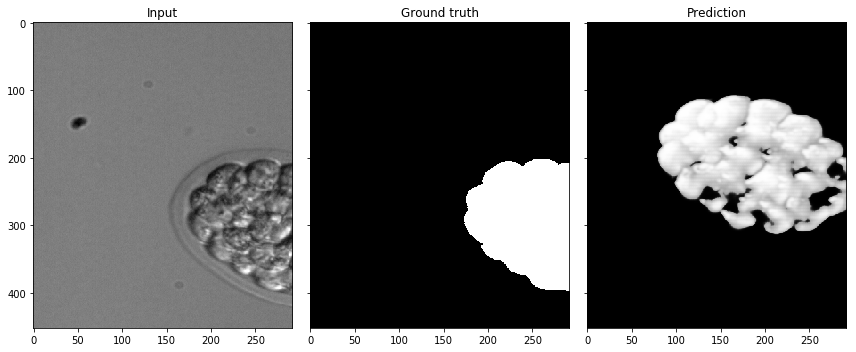

In [68]:
pruebas_broad_003.test(model_broad_003, data_provider_broad_003_test, TRAINED_FOLDER_BROAD_003)

### Broad Bioimage Benchmark Collection (BBBC005)
- https://data.broadinstitute.org/bbbc/image_sets.html

In [78]:
PATH_BROAD_005_TRAIN = "dataset/broad-bioimage/BBBC005/train/"
PATH_BROAD_005_TEST = "dataset/broad-bioimage/BBBC005/test/"
TRAINED_FOLDER_BROAD_005 = "unet_trained_broad_005"
#########################
#True: Volver a entrenar el modelo
#False: Reutiliza los modelos ya entrenados con formado ckpt
#########################
ENTRENAR_BROAD_005_MODEL = False 

Train

In [71]:
data_provider_broad_005_train = ImageDataProvider(PATH_BROAD_005_TRAIN + "*.tif")

Number of files used: 28


In [72]:
#Ejecuta esta línea para reflejar los cambios en la clase Pruebas
pruebas_broad_005 = Pruebas();

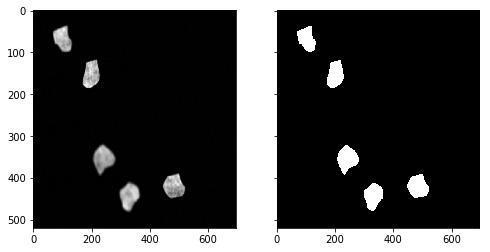

2018-09-30 15:31:18,655 Layers 5, features 32, filter size 3x3, pool size: 2x2
2018-09-30 15:31:20,416 Removing 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\prediction_unet_trained_broad_005'
2018-09-30 15:31:20,427 Removing 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\unet_trained_broad_005'
2018-09-30 15:31:20,453 Allocating 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\prediction_unet_trained_broad_005'
2018-09-30 15:31:20,455 Allocating 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\unet_trained_broad_005'
2018-09-30 15:31:24,309 Verification error= 97.0%, loss= 0.7268
2018-09-30 15:31:24,929 Start optimization
2018-09-30 15:31:29,589 Iter 0, Minibatch Loss= 0.5083, Training Accuracy= 0.9856, Minibatch error= 1.4%
2018-09-30 15:31:30,884 Iter 2, Minibatch Loss= 0.1659, Training Accuracy= 0.9802, Minibatch error= 2.0%
2018-09-30 15:31:32,202 Iter 4, Minibatch Loss= 0.2632, Training Accuracy= 0.9305, Minibatch e

2018-09-30 15:33:02,438 Iter 132, Minibatch Loss= 0.0498, Training Accuracy= 0.9312, Minibatch error= 6.9%
2018-09-30 15:33:03,712 Iter 134, Minibatch Loss= 0.0144, Training Accuracy= 0.9799, Minibatch error= 2.0%
2018-09-30 15:33:04,975 Iter 136, Minibatch Loss= 0.0451, Training Accuracy= 0.9372, Minibatch error= 6.3%
2018-09-30 15:33:06,227 Iter 138, Minibatch Loss= 0.0144, Training Accuracy= 0.9799, Minibatch error= 2.0%
2018-09-30 15:33:07,532 Iter 140, Minibatch Loss= 0.0122, Training Accuracy= 0.9845, Minibatch error= 1.6%
2018-09-30 15:33:08,797 Iter 142, Minibatch Loss= 0.0259, Training Accuracy= 0.9654, Minibatch error= 3.5%
2018-09-30 15:33:10,081 Iter 144, Minibatch Loss= 0.0394, Training Accuracy= 0.9461, Minibatch error= 5.4%
2018-09-30 15:33:11,356 Iter 146, Minibatch Loss= 0.0077, Training Accuracy= 0.9907, Minibatch error= 0.9%
2018-09-30 15:33:12,620 Iter 148, Minibatch Loss= 0.0254, Training Accuracy= 0.9658, Minibatch error= 3.4%
2018-09-30 15:33:13,882 Iter 150, Min

2018-09-30 15:34:43,072 Iter 276, Minibatch Loss= 0.0497, Training Accuracy= 0.9312, Minibatch error= 6.9%
2018-09-30 15:34:44,351 Iter 278, Minibatch Loss= 0.0091, Training Accuracy= 0.9881, Minibatch error= 1.2%
2018-09-30 15:34:45,640 Iter 280, Minibatch Loss= 0.0362, Training Accuracy= 0.9500, Minibatch error= 5.0%
2018-09-30 15:34:46,925 Iter 282, Minibatch Loss= 0.0254, Training Accuracy= 0.9658, Minibatch error= 3.4%
2018-09-30 15:34:48,210 Iter 284, Minibatch Loss= 0.0450, Training Accuracy= 0.9372, Minibatch error= 6.3%
2018-09-30 15:34:49,496 Iter 286, Minibatch Loss= 0.0136, Training Accuracy= 0.9829, Minibatch error= 1.7%
2018-09-30 15:34:49,927 Epoch 8, Average loss: 0.0246, learning rate: 0.1327
2018-09-30 15:34:50,801 Verification error= 3.0%, loss= 0.0222
2018-09-30 15:34:52,668 Iter 288, Minibatch Loss= 0.0260, Training Accuracy= 0.9654, Minibatch error= 3.5%
2018-09-30 15:34:53,981 Iter 290, Minibatch Loss= 0.0109, Training Accuracy= 0.9855, Minibatch error= 1.4%
2018

2018-09-30 15:36:22,159 Iter 416, Minibatch Loss= 0.0065, Training Accuracy= 0.9917, Minibatch error= 0.8%
2018-09-30 15:36:23,440 Iter 418, Minibatch Loss= 0.0141, Training Accuracy= 0.9825, Minibatch error= 1.8%
2018-09-30 15:36:24,753 Iter 420, Minibatch Loss= 0.0109, Training Accuracy= 0.9857, Minibatch error= 1.4%
2018-09-30 15:36:26,046 Iter 422, Minibatch Loss= 0.0148, Training Accuracy= 0.9802, Minibatch error= 2.0%
2018-09-30 15:36:27,301 Iter 424, Minibatch Loss= 0.0507, Training Accuracy= 0.9305, Minibatch error= 6.9%
2018-09-30 15:36:28,574 Iter 426, Minibatch Loss= 0.0042, Training Accuracy= 0.9947, Minibatch error= 0.5%
2018-09-30 15:36:29,820 Iter 428, Minibatch Loss= 0.0246, Training Accuracy= 0.9670, Minibatch error= 3.3%
2018-09-30 15:36:31,122 Iter 430, Minibatch Loss= 0.0110, Training Accuracy= 0.9856, Minibatch error= 1.4%
2018-09-30 15:36:32,375 Iter 432, Minibatch Loss= 0.0497, Training Accuracy= 0.9319, Minibatch error= 6.8%
2018-09-30 15:36:33,648 Iter 434, Min

2018-09-30 15:38:01,969 Iter 560, Minibatch Loss= 0.0052, Training Accuracy= 0.9935, Minibatch error= 0.7%
2018-09-30 15:38:03,252 Iter 562, Minibatch Loss= 0.0496, Training Accuracy= 0.9319, Minibatch error= 6.8%
2018-09-30 15:38:04,535 Iter 564, Minibatch Loss= 0.0144, Training Accuracy= 0.9799, Minibatch error= 2.0%
2018-09-30 15:38:05,839 Iter 566, Minibatch Loss= 0.0109, Training Accuracy= 0.9857, Minibatch error= 1.4%
2018-09-30 15:38:07,111 Iter 568, Minibatch Loss= 0.0106, Training Accuracy= 0.9874, Minibatch error= 1.3%
2018-09-30 15:38:08,416 Iter 570, Minibatch Loss= 0.0109, Training Accuracy= 0.9855, Minibatch error= 1.4%
2018-09-30 15:38:09,698 Iter 572, Minibatch Loss= 0.0497, Training Accuracy= 0.9312, Minibatch error= 6.9%
2018-09-30 15:38:10,964 Iter 574, Minibatch Loss= 0.0286, Training Accuracy= 0.9613, Minibatch error= 3.9%
2018-09-30 15:38:11,392 Epoch 17, Average loss: 0.0219, learning rate: 0.0836
2018-09-30 15:38:12,268 Verification error= 3.0%, loss= 0.0222
201

In [73]:
#########################
#train(data_provider, folder, train_iter, epoch, train)
#Al terminar el entrenamiento se recomienda guardar el contenido de la carpeta unet_trained_broad_005
#########################
model_broad_005 = pruebas_broad_005.train(data_provider_broad_005_train, 
                                          TRAINED_FOLDER_BROAD_005, 
                                          32, #iterations
                                          20, #epoch
                                          1, #batch size
                                          5, #layers
                                          32, #features
                                          0.5, #momentum 
                                          ENTRENAR_BROAD_005_MODEL)

Test

In [76]:
data_provider_broad_005_test = ImageDataProvider(PATH_BROAD_005_TEST + "*.tif")

Number of files used: 28


INFO:tensorflow:Restoring parameters from ./unet_trained_broad_005/model.ckpt


2018-09-30 15:39:48,979 Restoring parameters from ./unet_trained_broad_005/model.ckpt
2018-09-30 15:39:49,226 Model restored from file: ./unet_trained_broad_005/model.ckpt


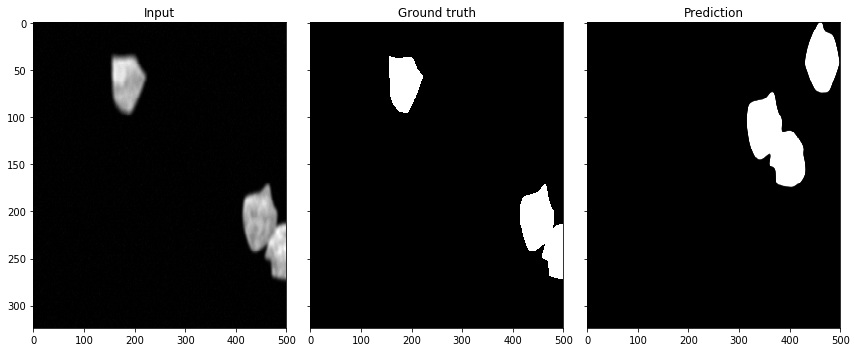

In [77]:
pruebas_broad_005.test(model_broad_005, data_provider_broad_005_test, TRAINED_FOLDER_BROAD_005)

###  Electron Microscopy Dataset
- Tomas del hipocampo
- Fuente: https://cvlab.epfl.ch/data/data-em/
- Resolución: 1024 x 768 x 165
- Podría ser utilizado como complemento del dataset EM segmentation challenge - ISBI 2012
- Se ha corrido con 10 épocas y aún no logra buenos resultados (hay que probarlo en la nube)

In [80]:
PATH_ELECTRON_MICROSCOPY_TRAIN = "dataset/electron-microscopy/train/"
PATH_ELECTRON_MICROSCOPY_TEST = "dataset/electron-microscopy/test/"
TRAINED_FOLDER_ELECTRON_MICROSCOPY = "unet_trained_electron_microscopy"
#########################
#True: Volver a entrenar el modelo
#False: Reutiliza los modelos ya entrenados con formado ckpt
#########################
ENTRENAR_ELECTRON_MICROSCOPY_MODEL = True 

Los archivos pesan más de 100mb, por lo que no podremos integrarlos al repositorio. Se procede a descargarlos por única vez.

In [81]:
#Descargar imágenes
URL_ELECTRON_MICROSCOPY_TRAIN = "https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/ ElectronMicroscopy_Hippocampus/training.tif"
URL_ELECTRON_MICROSCOPY_TRAIN_MASK = "https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/ ElectronMicroscopy_Hippocampus/training_groundtruth.tif"
URL_ELECTRON_MICROSCOPY_TEST = "https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/ ElectronMicroscopy_Hippocampus/testing.tif"
URL_ELECTRON_MICROSCOPY_TEST_MASK = "https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/ ElectronMicroscopy_Hippocampus/testing_groundtruth.tif"

def crear_carpetas():
    try:
        os.mkdir("dataset/electron-microscopy/")
        os.mkdir("dataset/electron-microscopy/train") 
        os.mkdir("dataset/electron-microscopy/test") 
        print("Las carpetas han sido creadas")
    except:
        print("Ya están creadas las carpetas")
        
def descargar_imagen(url, path):
    if not os.path.exists(path):
        print("Descargando " + path)
        wget.download(url=url, out=path)

In [82]:
crear_carpetas()
descargar_imagen(URL_ELECTRON_MICROSCOPY_TRAIN, 'dataset/electron-microscopy/train/training.tif')
descargar_imagen(URL_ELECTRON_MICROSCOPY_TRAIN_MASK, 'dataset/electron-microscopy/train/training_mask.tif')
descargar_imagen(URL_ELECTRON_MICROSCOPY_TEST, 'dataset/electron-microscopy/test/testing.tif')
descargar_imagen(URL_ELECTRON_MICROSCOPY_TEST_MASK, 'dataset/electron-microscopy/test/testing_mask.tif')

Ya están creadas las carpetas


Train

In [83]:
data_provider_electron_microscopy_train = ImageDataProvider(PATH_ELECTRON_MICROSCOPY_TRAIN + "*.tif")

Number of files used: 1


In [84]:
#Ejecuta esta línea para reflejar los cambios en la clase Pruebas
pruebas_electron_microscopy = Pruebas();

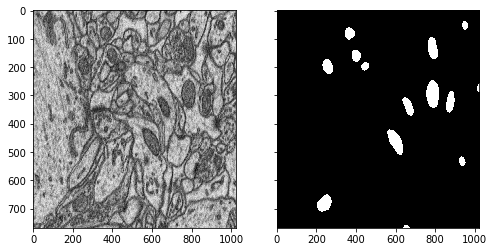

2018-09-30 15:42:22,679 Layers 5, features 16, filter size 3x3, pool size: 2x2
2018-09-30 15:42:24,400 Removing 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\prediction_unet_trained_electron_microscopy'
2018-09-30 15:42:24,419 Removing 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\unet_trained_electron_microscopy'
2018-09-30 15:42:24,511 Allocating 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\prediction_unet_trained_electron_microscopy'
2018-09-30 15:42:24,511 Allocating 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\unet_trained_electron_microscopy'
2018-09-30 15:42:28,892 Verification error= 93.8%, loss= 0.7793
2018-09-30 15:42:29,957 Start optimization
2018-09-30 15:42:35,506 Iter 0, Minibatch Loss= 0.6347, Training Accuracy= 0.9434, Minibatch error= 5.7%
2018-09-30 15:42:37,174 Iter 2, Minibatch Loss= 0.4935, Training Accuracy= 0.9280, Minibatch error= 7.2%
2018-09-30 15:42:38,823 Iter 4, Minibatch Loss= 0.2854

2018-09-30 15:44:33,214 Iter 130, Minibatch Loss= 0.2086, Training Accuracy= 0.9160, Minibatch error= 8.4%
2018-09-30 15:44:34,928 Iter 132, Minibatch Loss= 0.1758, Training Accuracy= 0.9295, Minibatch error= 7.0%
2018-09-30 15:44:36,576 Iter 134, Minibatch Loss= 0.2252, Training Accuracy= 0.9071, Minibatch error= 9.3%
2018-09-30 15:44:38,266 Iter 136, Minibatch Loss= 0.1512, Training Accuracy= 0.9440, Minibatch error= 5.6%
2018-09-30 15:44:39,940 Iter 138, Minibatch Loss= 0.1678, Training Accuracy= 0.9368, Minibatch error= 6.3%
2018-09-30 15:44:41,646 Iter 140, Minibatch Loss= 0.1691, Training Accuracy= 0.9354, Minibatch error= 6.5%
2018-09-30 15:44:43,278 Iter 142, Minibatch Loss= 0.1967, Training Accuracy= 0.9188, Minibatch error= 8.1%
2018-09-30 15:44:44,931 Iter 144, Minibatch Loss= 0.2093, Training Accuracy= 0.9081, Minibatch error= 9.2%
2018-09-30 15:44:46,590 Iter 146, Minibatch Loss= 0.1573, Training Accuracy= 0.9396, Minibatch error= 6.0%
2018-09-30 15:44:48,243 Iter 148, Min

2018-09-30 15:46:42,037 Iter 274, Minibatch Loss= 0.1200, Training Accuracy= 0.9367, Minibatch error= 6.3%
2018-09-30 15:46:43,679 Iter 276, Minibatch Loss= 0.1351, Training Accuracy= 0.9334, Minibatch error= 6.7%
2018-09-30 15:46:45,328 Iter 278, Minibatch Loss= 0.1306, Training Accuracy= 0.9358, Minibatch error= 6.4%
2018-09-30 15:46:46,992 Iter 280, Minibatch Loss= 0.1338, Training Accuracy= 0.9365, Minibatch error= 6.3%
2018-09-30 15:46:48,678 Iter 282, Minibatch Loss= 0.1543, Training Accuracy= 0.9151, Minibatch error= 8.5%
2018-09-30 15:46:50,333 Iter 284, Minibatch Loss= 0.1289, Training Accuracy= 0.9430, Minibatch error= 5.7%
2018-09-30 15:46:51,990 Iter 286, Minibatch Loss= 0.1369, Training Accuracy= 0.9350, Minibatch error= 6.5%
2018-09-30 15:46:52,515 Epoch 8, Average loss: 0.1387, learning rate: 0.1327
2018-09-30 15:46:53,579 Verification error= 6.2%, loss= 0.1297
2018-09-30 15:46:55,935 Iter 288, Minibatch Loss= 0.1451, Training Accuracy= 0.9219, Minibatch error= 7.8%
2018

2018-09-30 15:48:47,419 Verification error= 6.2%, loss= 0.1318
2018-09-30 15:48:49,754 Iter 416, Minibatch Loss= 0.1421, Training Accuracy= 0.9179, Minibatch error= 8.2%
2018-09-30 15:48:51,349 Iter 418, Minibatch Loss= 0.1296, Training Accuracy= 0.9153, Minibatch error= 8.5%
2018-09-30 15:48:53,015 Iter 420, Minibatch Loss= 0.0874, Training Accuracy= 0.9529, Minibatch error= 4.7%
2018-09-30 15:48:54,629 Iter 422, Minibatch Loss= 0.0944, Training Accuracy= 0.9500, Minibatch error= 5.0%
2018-09-30 15:48:56,227 Iter 424, Minibatch Loss= 0.1259, Training Accuracy= 0.9269, Minibatch error= 7.3%
2018-09-30 15:48:57,857 Iter 426, Minibatch Loss= 0.1244, Training Accuracy= 0.9262, Minibatch error= 7.4%
2018-09-30 15:48:59,435 Iter 428, Minibatch Loss= 0.1355, Training Accuracy= 0.9141, Minibatch error= 8.6%
2018-09-30 15:49:01,044 Iter 430, Minibatch Loss= 0.0796, Training Accuracy= 0.9562, Minibatch error= 4.4%
2018-09-30 15:49:02,703 Iter 432, Minibatch Loss= 0.1163, Training Accuracy= 0.93

2018-09-30 15:50:56,632 Iter 558, Minibatch Loss= 0.1260, Training Accuracy= 0.9143, Minibatch error= 8.6%
2018-09-30 15:50:58,241 Iter 560, Minibatch Loss= 0.1260, Training Accuracy= 0.9169, Minibatch error= 8.3%
2018-09-30 15:50:59,960 Iter 562, Minibatch Loss= 0.1753, Training Accuracy= 0.9152, Minibatch error= 8.5%
2018-09-30 15:51:01,966 Iter 564, Minibatch Loss= 0.0730, Training Accuracy= 0.9578, Minibatch error= 4.2%
2018-09-30 15:51:03,577 Iter 566, Minibatch Loss= 0.0726, Training Accuracy= 0.9598, Minibatch error= 4.0%
2018-09-30 15:51:05,241 Iter 568, Minibatch Loss= 0.1143, Training Accuracy= 0.9423, Minibatch error= 5.8%
2018-09-30 15:51:06,856 Iter 570, Minibatch Loss= 0.0780, Training Accuracy= 0.9560, Minibatch error= 4.4%
2018-09-30 15:51:08,476 Iter 572, Minibatch Loss= 0.1129, Training Accuracy= 0.9367, Minibatch error= 6.3%
2018-09-30 15:51:10,185 Iter 574, Minibatch Loss= 0.1124, Training Accuracy= 0.9405, Minibatch error= 6.0%
2018-09-30 15:51:10,765 Epoch 17, Ave

2018-09-30 15:53:06,577 Iter 702, Minibatch Loss= 0.1191, Training Accuracy= 0.9135, Minibatch error= 8.6%
2018-09-30 15:53:07,121 Epoch 21, Average loss: 0.1179, learning rate: 0.0681
2018-09-30 15:53:08,177 Verification error= 6.2%, loss= 0.1043
2018-09-30 15:53:10,706 Iter 704, Minibatch Loss= 0.1045, Training Accuracy= 0.9405, Minibatch error= 6.0%
2018-09-30 15:53:12,423 Iter 706, Minibatch Loss= 0.0725, Training Accuracy= 0.9528, Minibatch error= 4.7%
2018-09-30 15:53:14,070 Iter 708, Minibatch Loss= 0.1046, Training Accuracy= 0.9390, Minibatch error= 6.1%
2018-09-30 15:53:15,713 Iter 710, Minibatch Loss= 0.1005, Training Accuracy= 0.9439, Minibatch error= 5.6%
2018-09-30 15:53:17,312 Iter 712, Minibatch Loss= 0.1184, Training Accuracy= 0.9219, Minibatch error= 7.8%
2018-09-30 15:53:18,926 Iter 714, Minibatch Loss= 0.0798, Training Accuracy= 0.9513, Minibatch error= 4.9%
2018-09-30 15:53:20,549 Iter 716, Minibatch Loss= 0.1316, Training Accuracy= 0.9139, Minibatch error= 8.6%
201

2018-09-30 15:55:16,203 Iter 842, Minibatch Loss= 0.0823, Training Accuracy= 0.9588, Minibatch error= 4.1%
2018-09-30 15:55:17,857 Iter 844, Minibatch Loss= 0.1187, Training Accuracy= 0.9131, Minibatch error= 8.7%
2018-09-30 15:55:19,477 Iter 846, Minibatch Loss= 0.1018, Training Accuracy= 0.9153, Minibatch error= 8.5%
2018-09-30 15:55:21,109 Iter 848, Minibatch Loss= 0.0995, Training Accuracy= 0.9358, Minibatch error= 6.4%
2018-09-30 15:55:22,778 Iter 850, Minibatch Loss= 0.0852, Training Accuracy= 0.9439, Minibatch error= 5.6%
2018-09-30 15:55:24,689 Iter 852, Minibatch Loss= 0.1021, Training Accuracy= 0.9156, Minibatch error= 8.4%
2018-09-30 15:55:26,308 Iter 854, Minibatch Loss= 0.1019, Training Accuracy= 0.9173, Minibatch error= 8.3%
2018-09-30 15:55:28,017 Iter 856, Minibatch Loss= 0.0891, Training Accuracy= 0.9314, Minibatch error= 6.9%
2018-09-30 15:55:29,679 Iter 858, Minibatch Loss= 0.1065, Training Accuracy= 0.9334, Minibatch error= 6.7%
2018-09-30 15:55:31,387 Iter 860, Min

2018-09-30 15:57:26,052 Iter 986, Minibatch Loss= 0.1043, Training Accuracy= 0.9133, Minibatch error= 8.7%
2018-09-30 15:57:27,705 Iter 988, Minibatch Loss= 0.0740, Training Accuracy= 0.9470, Minibatch error= 5.3%
2018-09-30 15:57:29,323 Iter 990, Minibatch Loss= 0.1149, Training Accuracy= 0.9149, Minibatch error= 8.5%
2018-09-30 15:57:29,879 Epoch 30, Average loss: 0.0966, learning rate: 0.0429
2018-09-30 15:57:30,908 Verification error= 6.2%, loss= 0.0931
2018-09-30 15:57:33,474 Iter 992, Minibatch Loss= 0.0513, Training Accuracy= 0.9585, Minibatch error= 4.2%
2018-09-30 15:57:35,074 Iter 994, Minibatch Loss= 0.1107, Training Accuracy= 0.9097, Minibatch error= 9.0%
2018-09-30 15:57:36,687 Iter 996, Minibatch Loss= 0.0539, Training Accuracy= 0.9575, Minibatch error= 4.2%
2018-09-30 15:57:38,330 Iter 998, Minibatch Loss= 0.0864, Training Accuracy= 0.9367, Minibatch error= 6.3%
2018-09-30 15:57:39,957 Iter 1000, Minibatch Loss= 0.0483, Training Accuracy= 0.9607, Minibatch error= 3.9%
20

2018-09-30 15:59:33,273 Iter 1126, Minibatch Loss= 0.0945, Training Accuracy= 0.9372, Minibatch error= 6.3%
2018-09-30 15:59:34,895 Iter 1128, Minibatch Loss= 0.1055, Training Accuracy= 0.9215, Minibatch error= 7.9%
2018-09-30 15:59:36,516 Iter 1130, Minibatch Loss= 0.0917, Training Accuracy= 0.9262, Minibatch error= 7.4%
2018-09-30 15:59:38,181 Iter 1132, Minibatch Loss= 0.0525, Training Accuracy= 0.9566, Minibatch error= 4.3%
2018-09-30 15:59:39,784 Iter 1134, Minibatch Loss= 0.1006, Training Accuracy= 0.9393, Minibatch error= 6.1%
2018-09-30 15:59:41,403 Iter 1136, Minibatch Loss= 0.0960, Training Accuracy= 0.9352, Minibatch error= 6.5%
2018-09-30 15:59:43,050 Iter 1138, Minibatch Loss= 0.0952, Training Accuracy= 0.9174, Minibatch error= 8.3%
2018-09-30 15:59:44,739 Iter 1140, Minibatch Loss= 0.0967, Training Accuracy= 0.9162, Minibatch error= 8.4%
2018-09-30 15:59:46,531 Iter 1142, Minibatch Loss= 0.0905, Training Accuracy= 0.9354, Minibatch error= 6.5%
2018-09-30 15:59:48,201 Iter

2018-09-30 16:01:42,459 Iter 1268, Minibatch Loss= 0.0988, Training Accuracy= 0.9152, Minibatch error= 8.5%
2018-09-30 16:01:44,112 Iter 1270, Minibatch Loss= 0.0636, Training Accuracy= 0.9498, Minibatch error= 5.0%
2018-09-30 16:01:45,749 Iter 1272, Minibatch Loss= 0.1082, Training Accuracy= 0.9160, Minibatch error= 8.4%
2018-09-30 16:01:47,370 Iter 1274, Minibatch Loss= 0.0556, Training Accuracy= 0.9592, Minibatch error= 4.1%
2018-09-30 16:01:49,027 Iter 1276, Minibatch Loss= 0.0714, Training Accuracy= 0.9509, Minibatch error= 4.9%
2018-09-30 16:01:50,722 Iter 1278, Minibatch Loss= 0.0471, Training Accuracy= 0.9591, Minibatch error= 4.1%
2018-09-30 16:01:51,260 Epoch 39, Average loss: 0.0884, learning rate: 0.0271
2018-09-30 16:01:52,293 Verification error= 6.2%, loss= 0.0890
2018-09-30 16:01:54,877 Iter 1280, Minibatch Loss= 0.0592, Training Accuracy= 0.9512, Minibatch error= 4.9%
2018-09-30 16:01:56,472 Iter 1282, Minibatch Loss= 0.0990, Training Accuracy= 0.9423, Minibatch error= 

2018-09-30 16:03:49,395 Verification error= 6.2%, loss= 0.0896
2018-09-30 16:03:52,003 Iter 1408, Minibatch Loss= 0.0887, Training Accuracy= 0.9296, Minibatch error= 7.0%
2018-09-30 16:03:53,709 Iter 1410, Minibatch Loss= 0.0708, Training Accuracy= 0.9519, Minibatch error= 4.8%
2018-09-30 16:03:55,339 Iter 1412, Minibatch Loss= 0.0917, Training Accuracy= 0.9182, Minibatch error= 8.2%
2018-09-30 16:03:56,971 Iter 1414, Minibatch Loss= 0.0729, Training Accuracy= 0.9509, Minibatch error= 4.9%
2018-09-30 16:03:58,635 Iter 1416, Minibatch Loss= 0.1019, Training Accuracy= 0.9163, Minibatch error= 8.4%
2018-09-30 16:04:00,280 Iter 1418, Minibatch Loss= 0.0960, Training Accuracy= 0.9156, Minibatch error= 8.4%
2018-09-30 16:04:01,949 Iter 1420, Minibatch Loss= 0.0827, Training Accuracy= 0.9309, Minibatch error= 6.9%
2018-09-30 16:04:03,576 Iter 1422, Minibatch Loss= 0.1062, Training Accuracy= 0.9149, Minibatch error= 8.5%
2018-09-30 16:04:05,206 Iter 1424, Minibatch Loss= 0.0788, Training Accur

2018-09-30 16:05:59,851 Iter 1550, Minibatch Loss= 0.0781, Training Accuracy= 0.9426, Minibatch error= 5.7%
2018-09-30 16:06:01,505 Iter 1552, Minibatch Loss= 0.0915, Training Accuracy= 0.9358, Minibatch error= 6.4%
2018-09-30 16:06:03,174 Iter 1554, Minibatch Loss= 0.0997, Training Accuracy= 0.9423, Minibatch error= 5.8%
2018-09-30 16:06:04,795 Iter 1556, Minibatch Loss= 0.0846, Training Accuracy= 0.9408, Minibatch error= 5.9%
2018-09-30 16:06:06,450 Iter 1558, Minibatch Loss= 0.0905, Training Accuracy= 0.9357, Minibatch error= 6.4%
2018-09-30 16:06:08,142 Iter 1560, Minibatch Loss= 0.0632, Training Accuracy= 0.9519, Minibatch error= 4.8%
2018-09-30 16:06:09,796 Iter 1562, Minibatch Loss= 0.0660, Training Accuracy= 0.9562, Minibatch error= 4.4%
2018-09-30 16:06:11,427 Iter 1564, Minibatch Loss= 0.0866, Training Accuracy= 0.9368, Minibatch error= 6.3%
2018-09-30 16:06:13,051 Iter 1566, Minibatch Loss= 0.0585, Training Accuracy= 0.9498, Minibatch error= 5.0%
2018-09-30 16:06:13,584 Epoc

In [85]:
#########################
#train(data_provider, folder, train_iter, epoch, train)
#Al terminar el entrenamiento se recomienda guardar el contenido de la carpeta unet_trained_broad_005
#Ej. 40 iteraciones x 4 batch size = 160 ejemplos. Tenemos 165 frames en la imagen
#Recomendaciones de batch: https://www.quora.com/What-are-the-usual-batch-sizes-people-use-to-train-neural-nets                     
#########################
model_electron_microscopy = pruebas_electron_microscopy.train(data_provider_electron_microscopy_train, 
                                          TRAINED_FOLDER_ELECTRON_MICROSCOPY, 
                                          32, #iterations
                                          50, #epoch
                                          1, #batch size
                                          5, #layers
                                          16, #features
                                          0.5, #momentum 
                                          ENTRENAR_ELECTRON_MICROSCOPY_MODEL)

Test

In [88]:
data_provider_electron_microscopy_test = ImageDataProvider(PATH_ELECTRON_MICROSCOPY_TEST + "*.tif")

Number of files used: 1


INFO:tensorflow:Restoring parameters from ./unet_trained_electron_microscopy/model.ckpt


2018-09-30 16:07:22,948 Restoring parameters from ./unet_trained_electron_microscopy/model.ckpt
2018-09-30 16:07:23,208 Model restored from file: ./unet_trained_electron_microscopy/model.ckpt


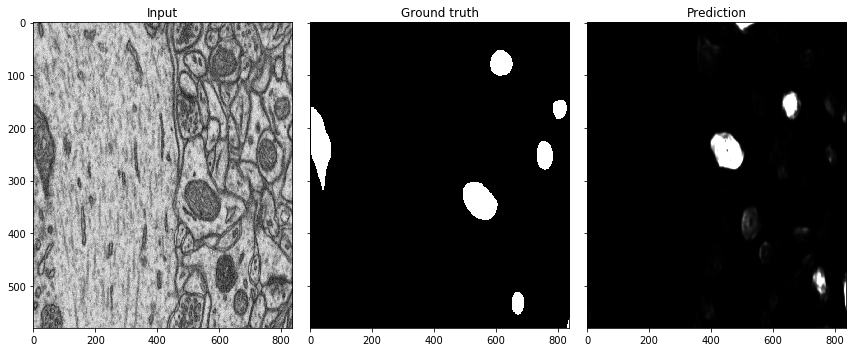

In [90]:
pruebas_electron_microscopy.test(model_electron_microscopy, 
                                 data_provider_electron_microscopy_test, 
                                 TRAINED_FOLDER_ELECTRON_MICROSCOPY)